In [1]:
import os
import glob
import itertools
from random import randint
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
# import seaborn
# plt.style.use('seaborn-white')
from pathlib import Path
import time

import matplotlib.cm as cm
from IPython.display import Image
import git

In [2]:
from rmgpy.molecule import Molecule
from rmgpy.data.base import Database

## Git-python: checkout master branch

In [28]:
import git
rmg_model_path = "../../../meOH-synthesis"
repo = git.Repo(rmg_model_path)
date = time.localtime(repo.head.commit.committed_date)
git_date = time.strftime("%Y_%m_%d_%H%M", date)
git_sha = str(repo.head.commit)[0:6]
git_msg = str(repo.head.commit.message)[0:50].replace(" ", "_").replace("'", "_").replace("\n", "")
git_file_string = f"{git_date}_{git_sha}_{git_msg}"
current_commit = git_file_string
current_commit

'2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates'

## checkout 1 commit back

In [29]:
# repo.git.checkout('HEAD^1')
# date = time.localtime(repo.head.commit.committed_date)
# git_date = f"{date[0]}_{date[1]}_{date[2]}_{date[3]}{date[4]}"
# git_sha = str(repo.head.commit)[0:6]
# git_msg = str(repo.head.commit.message)[0:50].replace(" ", "_").replace("'", "_").replace("\n", "")
# git_file_string = f"{git_date}_{git_sha}_{git_msg}"
# current_commit = git_file_string

## checkout 2 commits back

In [30]:
# repo.git.checkout('HEAD^1')
# date = time.localtime(repo.head.commit.committed_date)
# git_date = f"{date[0]}_{date[1]}_{date[2]}_{date[3]}{date[4]}"
# git_sha = str(repo.head.commit)[0:6]
# git_msg = str(repo.head.commit.message)[0:50].replace(" ", "_").replace("'", "_").replace("\n", "")
# git_file_string = f"{git_date}_{git_sha}_{git_msg}"
# current_commit = git_file_string

## Read in data

In [31]:
commit_list = []

# determine which files/folder to exclude

# exclude grabow data
grabow = False
grabow_str = "0000_00_00_0000_000000_Grabow model"
test_csv = "average_common_sensitivities"
single_csv = "single_reactor_results.csv"

if grabow: 
    exclude_files = [test_csv, single_csv]
else: 
    exclude_files = [grabow_str, test_csv, single_csv]
    
# read in each commit folder. 
for path in Path('../').rglob('*.csv'):
    path_str = str(path)
    start_index = path_str.find('../RMG_model_analysis/')
    
    if start_index != -1 and not any(x in path_str for x in exclude_files):
        commit = path_str.split('/')[2]
        if commit not in commit_list:
            commit_list.append(commit)
        
print(commit_list)   

['2021_08_19_1424_e3a38d_added_gitignore', '2021_09_01_0908_7a10e2_ran_with_Bjarne_s_new_families,_and_grabow_rates', '2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates']


In [32]:
# read last line from each CSV file
data_dict = {}

# exclude CSP, steady state, and non - sensitivity data
exclude = ["/csp/", "/steady_state/", "sensitivity_on"]

# if true, runs analysis on current commit only
one_commit = True
if one_commit == True:
    commit_list = [current_commit]

for commit in commit_list:
    first_file = True
    for path in Path(commit).rglob('*.csv'):
        path_str = str(path)
        if all(f not in path_str for f in exclude):
            if os.stat(path_str).st_size != 0:
                if first_file == True: 
                    data = pd.read_csv(path_str)
                    aggdata = data.tail(1)
                    first_file = False
                    print(path)                    
                else: 
                    data = pd.read_csv(path_str)
                    aggdata = aggdata.append(data.tail(1))
                    print(len(aggdata))
                    print(path)
            
    data_dict.update({commit:aggdata})
    


## Turn over frequency comparison

The mechanisms listed below are the pathways that are of interest in TOF.



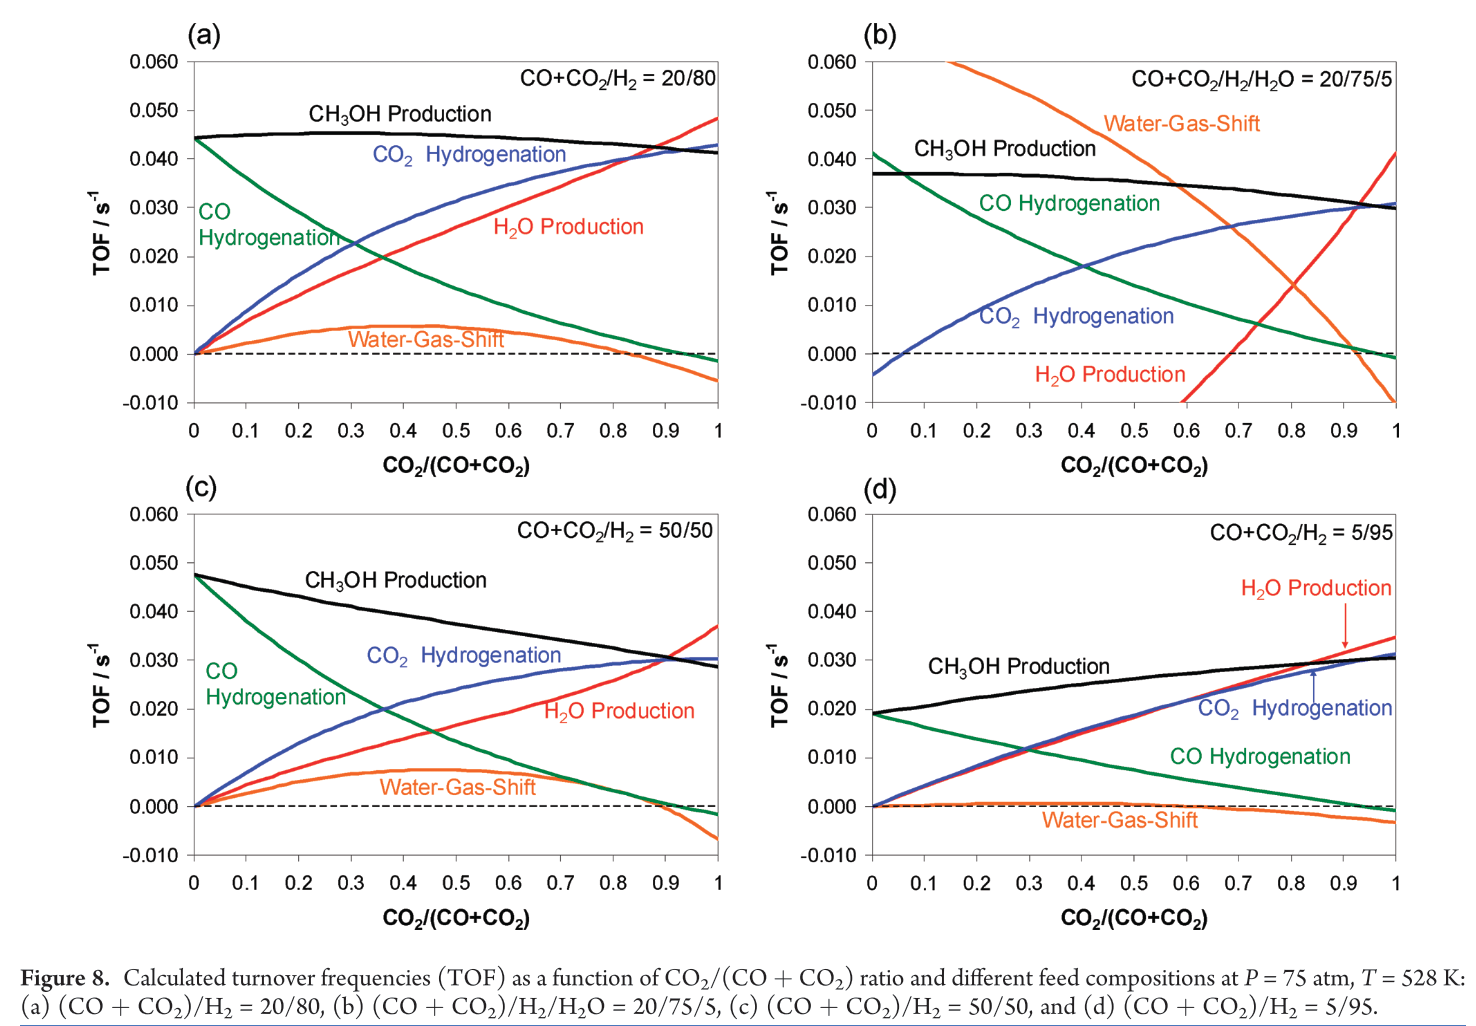

In [8]:
Image('../images/Grabow_plots/Grabow_TOF.png',width = 700, height = 300)

In [9]:
commit_list

['2021_09_01_0908_7a10e2_ran_with_Bjarne_s_new_families,_and_grabow_rates']

{0.5, 0.75, 0.8, 0.95}


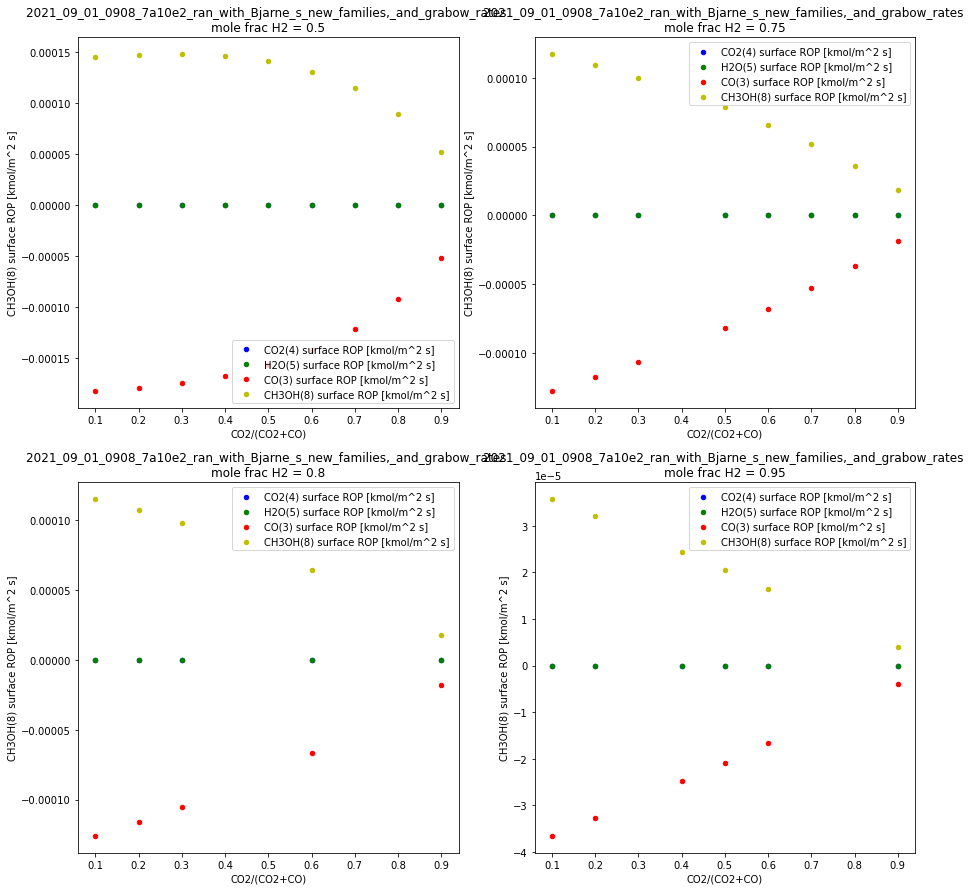

In [11]:
# compare the rate of production for CO2,  H2O, CO, and CH3OH
%matplotlib inline
for commit in commit_list:
    
    if "0000_00_00_0000_000000_Grabow model" in commit:
        conditions = ['CO2 ROP [kmol/m^3 s]', 'H2O surface ROP [kmol/m^2 s]', \
                     'CO surface ROP [kmol/m^2 s]', 'CH3OH surface ROP [kmol/m^2 s]']
    else:
        conditions = ['CO2(4) surface ROP [kmol/m^2 s]', 'H2O(5) surface ROP [kmol/m^2 s]', \
                     'CO(3) surface ROP [kmol/m^2 s]', 'CH3OH(8) surface ROP [kmol/m^2 s]']
    temp = 500

    # get keys for H2 (X_h2 initial)
    H2_ratio = data_dict[commit_list[0]]['X_h2 initial'].unique()
    H2_ratio = set([round(i,2) for i in H2_ratio])
    print(H2_ratio)

    fig, ax = plt.subplots(2,2,figsize=(15,15))

    color_dict = { 0:"b", 1:"g", 2:"r", 3:"y"}
    for p,j in enumerate(H2_ratio):
        if p == 0:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,0], color=color_dict[c])
                ax[0,0].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,0].autoscale(enable=True, axis='y')
        if p == 1:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,1], color=color_dict[c])
                ax[0,1].set_title(f'{commit} \nmole frac H2 = {j}')

        if p == 2:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,0], color=color_dict[c])
                ax[1,0].set_title(f'{commit} \nmole frac H2 = {j}')

        if p == 3:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,1], color=color_dict[c])
                ax[1,1].set_title(f'{commit} \nmole frac H2 = {j}')
            



In [20]:
commit_list[0]

'2021_08_03_1507_9ae615_ran_meoh_model_with_latest_RMG-Py_and_DB'

In [13]:
# get the maximum values
max_dist = 2
imp_species = []

df_short = data_dict[commit_list[0]]

thresh = 1e-4

for c in commit_list:
    print(f'\n{c}\nSpecies Steady state concentrations that go above :{thresh}', '\n')
    df_short = data_dict[c]
    for i in range (15, len(df_short.columns)):

        column = df_short[df_short.columns[i]]
        max_value = column.max()
        max_index = column.idxmax()

        if max_value >= thresh and (("X" in df_short.columns[i]) or \
                                  ("Pt" in df_short.columns[i]) or \
                                  ("Pd" in df_short.columns[i]) or \
                                  ("*" in df_short.columns[i])) \
        and not "ROP" in df_short.columns[i] \
        and not "sensitivity" in df_short.columns[i]:

            imp_species.append(df_short.columns[i])
            print(df_short.columns[i], "Max = " "{:.10f}".format(max_value))
        
    



2021_09_01_0908_7a10e2_ran_with_Bjarne_s_new_families,_and_grabow_rates
Species Steady state concentrations that go above :0.0001 

X(1) Max = 0.1539850225
H*(10) Max = 0.0066606204
H2O*(13) Max = 0.0009972837
CO*(14) Max = 0.9745890267
HCO*(16) Max = 0.0055258423
CH2O*(20) Max = 0.0002193583
CH3OH*(23) Max = 0.0033764418
H2X(53) Max = 0.9065452851


['X(1)', 'H*(10)', 'H2O*(13)', 'CO*(14)', 'HCO*(16)', 'CH2O*(20)', 'CH3OH*(23)', 'H2X(53)']


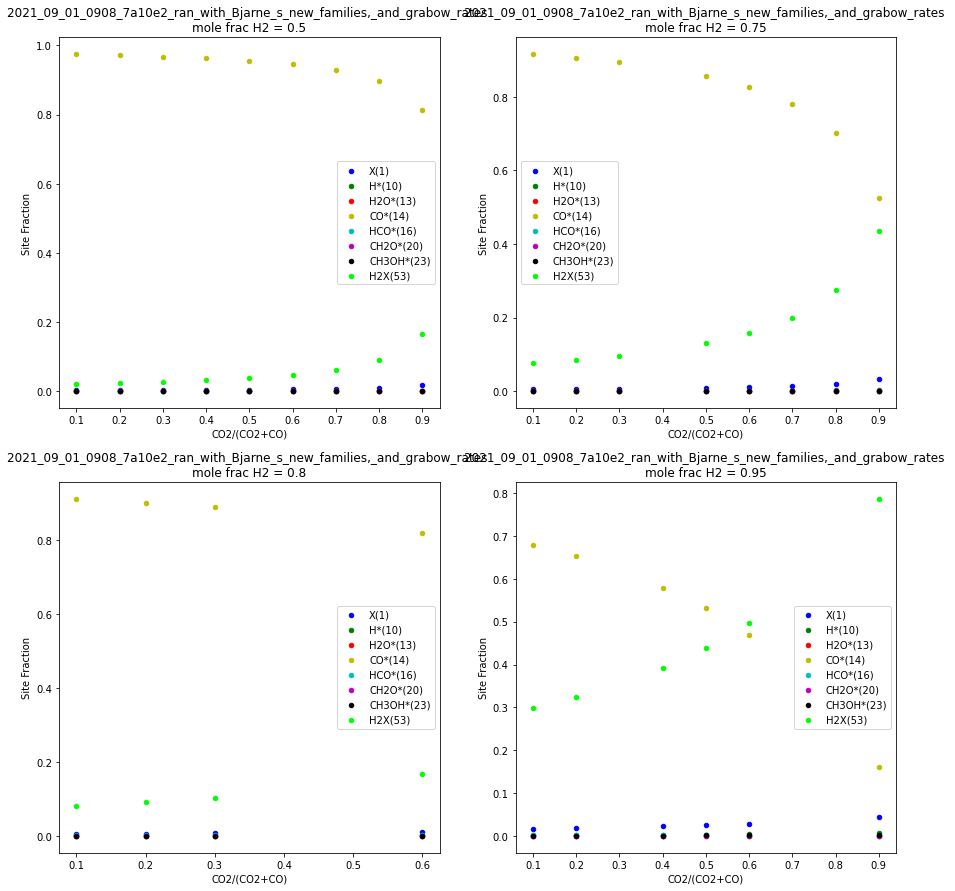

In [14]:
# compare the rate of production for CO2,  H2O, CO, and CH3OH
for commit in commit_list:
# commit = commit_list[0] 

    conditions = imp_species[:8]
    temp = 400

    # get keys for H2 (X_h2 initial)
    H2_ratio = data_dict[commit_list[0]]['X_h2 initial'].unique()
    H2_ratio = set([round(i,2) for i in H2_ratio])
    print(conditions)

    fig, ax = plt.subplots(2,2,figsize=(15,15))

    color_dict = { 0:"b", 1:"g", 2:"r", 3:"y", 4:"c", 5:"m", 6: "k", 7: "lime" , 8:"brown"}
    for p,j in enumerate(H2_ratio):
        if p == 0:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,0], color=color_dict[c])
                ax[0,0].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,0].set_ylabel("Site Fraction")
        if p == 1:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,1], color=color_dict[c])
                ax[0,1].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,1].set_ylabel("Site Fraction")
        if p == 2:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,0], color=color_dict[c],)
                ax[1,0].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[1,0].set_ylabel("Site Fraction")
        if p == 3:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,1], color=color_dict[c])
                ax[1,1].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[1,1].set_ylabel("Site Fraction")

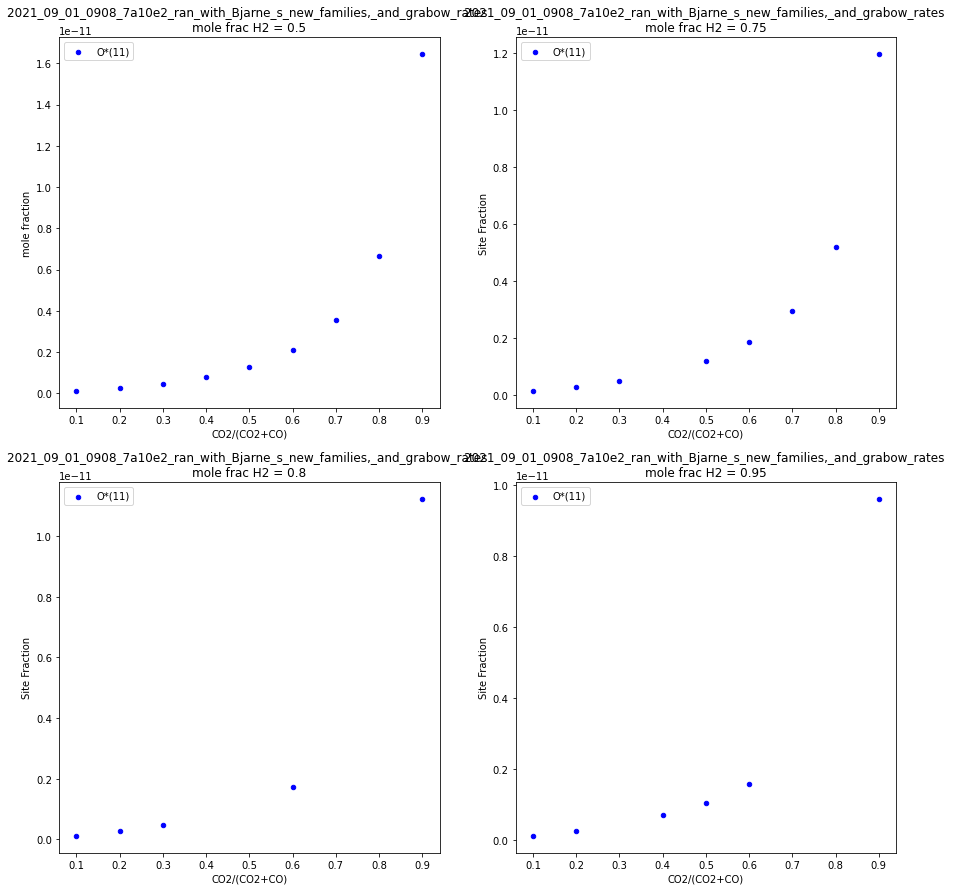

In [15]:
for commit in commit_list:
# commit = 'a95dd5_added_new_family_sur'  

    conditions = ["O*(11)"]
#     conditions = ["OX"]
    temp = 500

    # get keys for H2 (X_h2 initial)
    H2_ratio = data_dict[commit_list[0]]['X_h2 initial'].unique()
    H2_ratio = set([round(i,2) for i in H2_ratio])
    
    fig, ax = plt.subplots(2,2,figsize=(15,15))

    color_dict = { 0:"b", 1:"g", 2:"r", 3:"y", 4:"c", 5:"m"}
    for p,j in enumerate(H2_ratio):
        if p == 0:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,0], color=color_dict[c])
                ax[0,0].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,0].set_ylabel("mole fraction")
        if p == 1:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,1], color=color_dict[c])
                ax[0,1].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[0,1].set_ylabel("Site Fraction")
        if p == 2:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,0], color=color_dict[c],)
                ax[1,0].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[1,0].set_ylabel("Site Fraction")
        if p == 3:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,1], color=color_dict[c])
                ax[1,1].set_title(f'{commit} \nmole frac H2 = {j}')
                ax[1,1].set_ylabel("Site Fraction")

## Surface coverage comparison


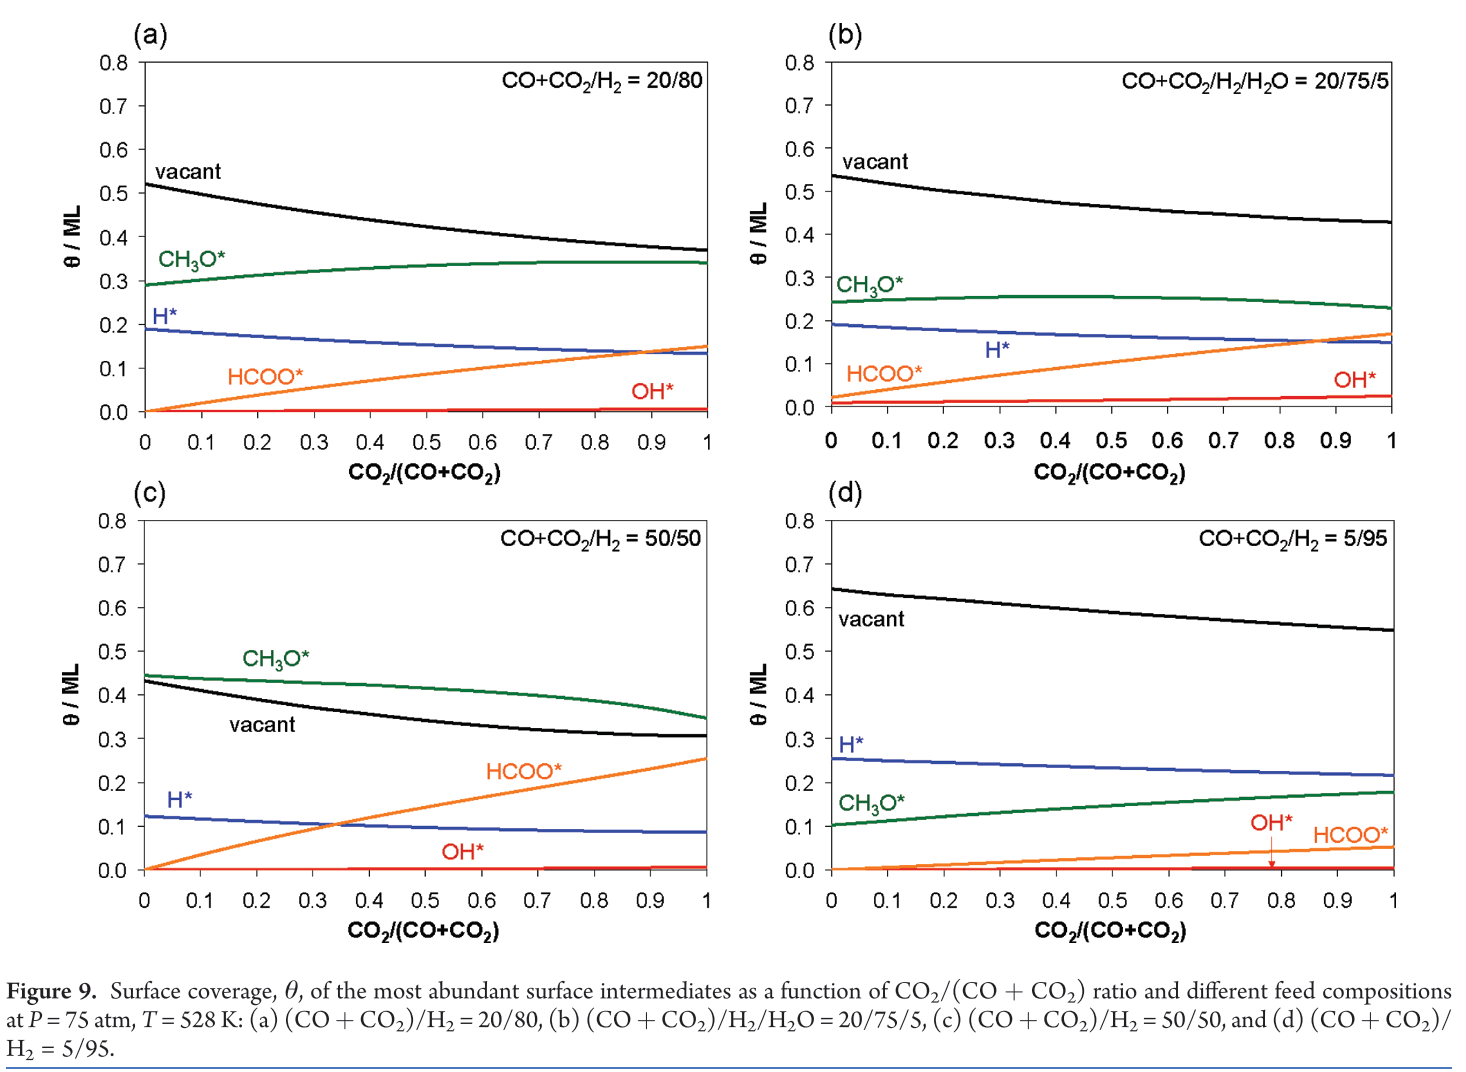

In [16]:
Image('../images/Grabow_plots/Grabow_coverage.png',width = 700, height = 300)

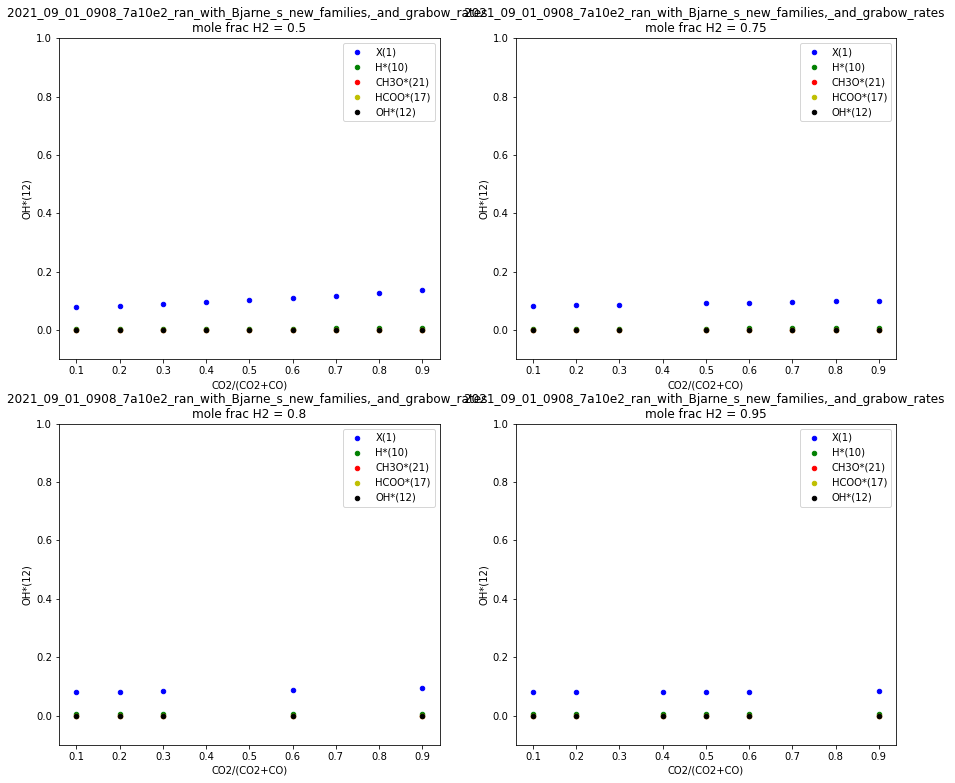

In [21]:
for commit in commit_list:  

    # removing HCOO because we ar using the wrong species
    conditions = ['X(1)', 'H*(10)', 'CH3O*(21)', 'HCOO*(17)', 'OH*(12)']
#     conditions = ['X(1)', 'H*(10)', 'HCOO*(17)', 'OH*(12)']
#     conditions = ['X', 'HX', 'HCOOX', 'OHX']   
    temp = 500

    # get keys for H2 (X_h2 initial)
    H2_ratio = data_dict[commit_list[0]]['X_h2 initial'].unique()
    H2_ratio = set([round(i,2) for i in H2_ratio])
    
    fig, ax = plt.subplots(2,2,figsize=(15,13))

    color_dict = { 0:"b", 1:"g", 2:"r", 3:"y", 4: "k"}
    for p,j in enumerate(H2_ratio):
        if p == 0:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,0], color=color_dict[c], ylim=[-0.1,1.0])
                ax[0,0].set_title(f'{commit} \nmole frac H2 = {j}')
        if p == 1:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[0,1], color=color_dict[c], ylim=[-0.1,1.0])
                ax[0,1].set_title(f'{commit} \nmole frac H2 = {j}')

        if p == 2:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,0], color=color_dict[c],ylim=[-0.1,1.0])
                ax[1,0].set_title(f'{commit} \nmole frac H2 = {j}')

        if p == 3:
            for c,i in enumerate(conditions):
                data_dict[commit][(data_dict[commit]['X_h2 initial'] == j) & (data_dict[commit]['T (K)'] == temp \
                    )].plot.scatter(x='CO2/(CO2+CO)', y=i, label=i, ax =ax[1,1], color=color_dict[c], ylim=[-0.1,1.0])
                ax[1,1].set_title(f'{commit} \nmole frac H2 = {j}')

## flux diagrams

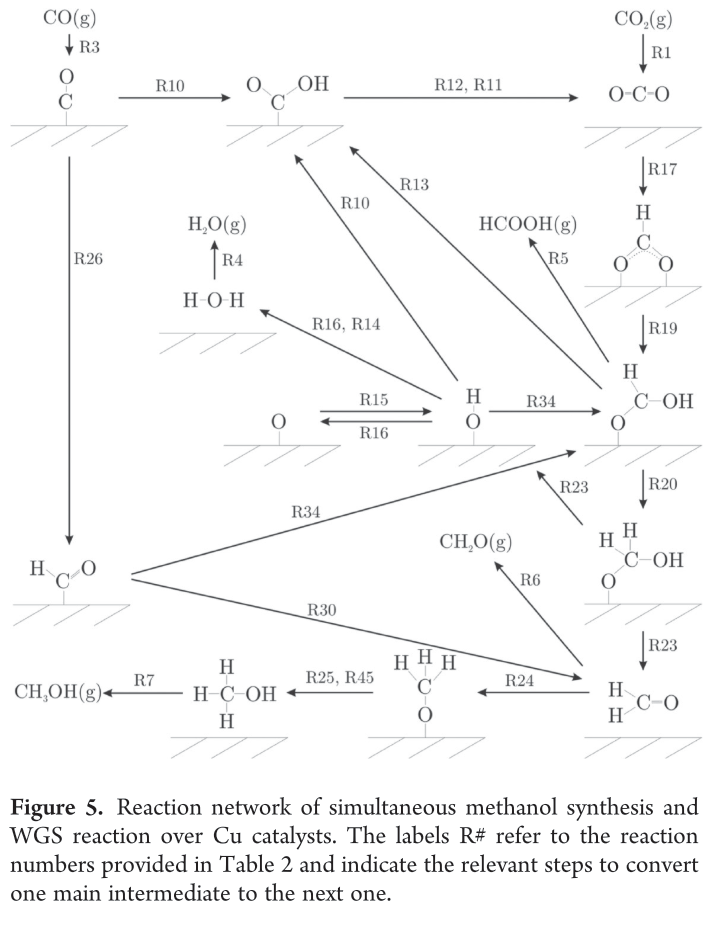

In [48]:
Image('../images/Grabow_plots/Grabow_rxn_path.png',width = 500, height = 300)

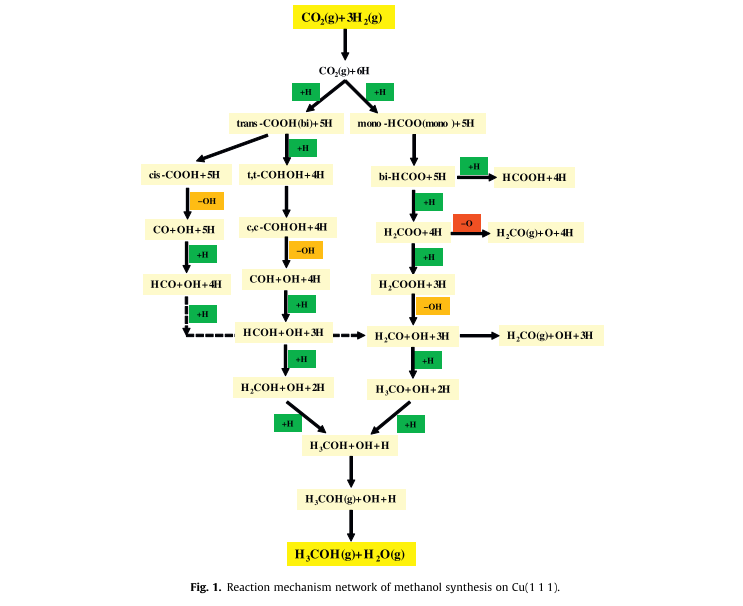

In [49]:
Image('../images/Reaction_mechanism_alternative.png',width = 700, height = 300)

description of commits: 


In [66]:
commit_list[1] = '2021_7_12_1054_62027c_covdep_with_bjarne_s_data_and_modified_H2X_vdw_bin'
commit_list

['2021_5_5_1342_199260_fixed_typo_in_Cu111_library_for_a5_nasa_parameter',
 '2021_7_12_1054_62027c_covdep_with_bjarne_s_data_and_modified_H2X_vdw_bin',
 '2021_7_8_957_6d7fec_ran_with__coverageDependence__set_to_true,_last_ru']

FileNotFoundError: [Errno 2] No such file or directory: '../RMG_wDeut/2021_09_01_0908_7a10e2_ran_with_Bjarne_s_new_families,_and_grabow_rates/transient/IdealGasReactor/energy_off/sensitivity_off/500/flux_diagrams/0_5/0_9/reaction_path_C_surface1_beginning-pretty.png'

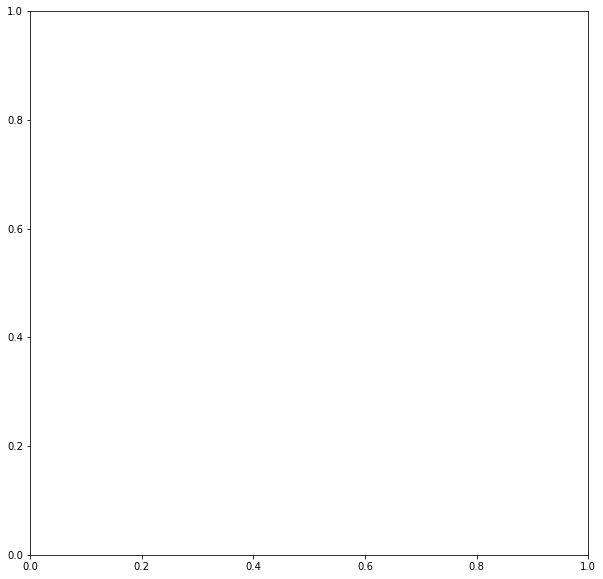

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import math

%matplotlib inline
img = []
flux_path = []

# determine # of rows and columns for displays
placeholder = [1,2,3,4,5]

one_commit = True


if one_commit == False:
    rcParams['figure.figsize'] = 30 ,30
    if len(commit_list)%2 == 0:
        rows = int(len(commit_list)/2)
    else: 
        rows = int(math.ceil(len(commit_list)/2))

    fig, ax = plt.subplots(rows,2)
    for i,commit in enumerate(commit_list):
        temp = 500 
        H2_frac = "0_5"
        CO_CO2 = "0_9"
        element = "O"
        phase = "surface1" # "surface1" "gas"
        time = "end" # "end" "beginning"
        prefix = '../RMG_wDeut/'
        flux_path.append(f'/transient/IdealGasReactor/energy_off/sensitivity_off/{temp}/flux_diagrams/{H2_frac}/{CO_CO2}/reaction_path_{element}_{phase}_{time}-pretty.png')

        print(commit)
        img.append(mpimg.imread(f'{prefix}{commit}{flux_path[i]}'))

        #determine placement of picture
        if i%2 == 0:
            row = int(i/2)-1
            col = 0
        else:
            row = int(math.ceil(i/2)) - 1
            col = 1

        ax[row,col].imshow(img[i])
        ax[row,col].get_xaxis().set_visible(False) 
        ax[row,col].get_yaxis().set_visible(False) 
        ax[row,col].set_title(f'{commit}', fontsize = 30)
        
else:
    rcParams['figure.figsize'] = 10 ,10
    fig, ax = plt.subplots(1,1)
    for i,commit in enumerate(commit_list):
        temp = 500 
        H2_frac = "0_5"
        CO_CO2 = "0_9"
        element = "C"
        phase = "surface1" # "surface1" "gas"
        time = "beginning" # "end" "beginning"
        prefix = '../RMG_wDeut/'
        flux_path.append(f'/transient/IdealGasReactor/energy_off/sensitivity_off/{temp}/flux_diagrams/{H2_frac}/{CO_CO2}/reaction_path_{element}_{phase}_{time}-pretty.png')


        img.append(mpimg.imread(f'{prefix}{commit}{flux_path[i]}'))

        ax.imshow(img[i])
        ax.get_xaxis().set_visible(False) 
        ax.get_yaxis().set_visible(False) 
        ax.set_title(f'{commit}', fontsize = 30)



In [38]:
one_commit

False

### pathway analysis

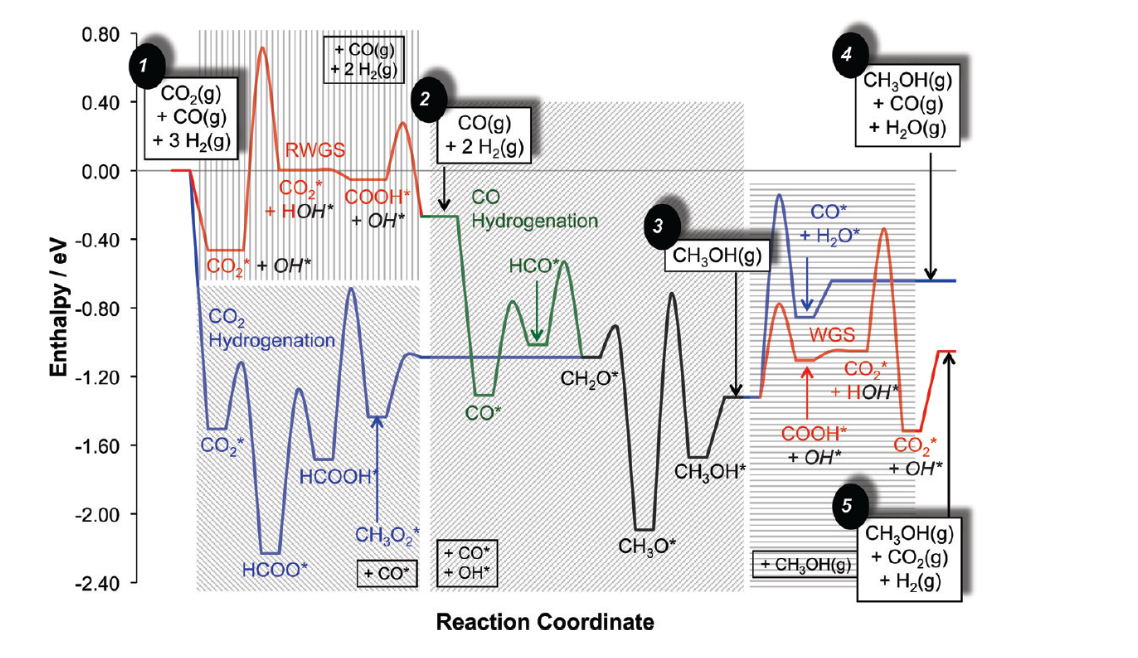

In [44]:
Image('../images/Grabow_plots/Grabow_PES.png',width = 1000, height = 300)

# Sensitivity

In [37]:
# load data into big data dictionary
sens_data_dict = {}
temps = [] 
X_h2s = []
X_coco2s = []

# excluded directories
exclude = ["/csp/", "/steady_state/", "sensitivity_off"]

for path in Path(commit).rglob('*.csv'):
    path_str = str(path)
    if os.stat(path_str).st_size != 0 and all(f not in path_str for f in exclude):
        data = pd.read_csv(path_str)
        
        #if we have more than 1 line of data, pull sensitivity
        if len(data['T (K)']) >= 1: 
            temp = round(float(data['T (K)'].unique()), 2)
            X_h2 = round(float(data['X_h2 initial'].unique()),2)
            X_coco2 = round(float(data['CO2/(CO2+CO)'].unique()),2)

            if temp not in temps: temps.append(temp)
            if X_h2 not in X_h2s: X_h2s.append(X_h2) 
            if X_coco2 not in X_coco2s: X_coco2s.append(X_coco2)

            sens_data_dict.update({(temp,X_h2,X_coco2) : data})
            print("!!!!!!!!!sim_passed", path_str)
        else:
            print(path_str)
            print("empty data, sim crashed")

In [46]:
def max_sensitivities(df, number=0):
    # make a dictionary of highest sensitivity (tuple?)
    columns = {}
    for key, value in df.iteritems():
        if "sensitivity" in key:
            max_sens = value.max()
            min_sens = value.min()
            
            if abs(max_sens) >= abs(min_sens):
                extreme_sens = max_sens
            elif abs(max_sens) < abs(min_sens):
                extreme_sens = min_sens
                
                
            columns.update({key:extreme_sens})

    if number !=0:
        columns = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=True)[:number])
        columns_rev = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=False)[:number])
    else: 
        columns = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=True))
        columns_rev = dict(sorted(columns.items(), key=lambda kv: kv[1], reverse=False))
    return columns, columns_rev


columns, columns_rev = max_sensitivities(sens_data_dict[400.0, 0.5, 0.5],5)
columns_rev

{'CH3OH(8) sensitivity to HCOOH(7) + 2 X(1) <=> COOH*(18) + H*(10)': 0.005743811869544466,
 'CH3OH(8) sensitivity to H2(2) + 2 X(1) <=> 2 H*(10)': 0.020674901917958403,
 'CH3OH(8) sensitivity to H*(10) + HCO*(16) <=> CH2O*(20) + X(1)': 0.14695289544190565,
 'CH3OH(8) sensitivity to CH2O*(20) + H*(10) <=> CH3O*(21) + X(1)': 1.9068191668770589,
 'CH3OH(8) sensitivity to CH2O*(20) + H*(10) <=> H2X(51) + HCO*(16)': 1.9352395976486612}

In [47]:
columns

{'CH3OH(8) sensitivity to CH2O*(20) + H*(10) <=> H2X(51) + HCO*(16)': 1.9352395976486612,
 'CH3OH(8) sensitivity to CH2O*(20) + H*(10) <=> CH3O*(21) + X(1)': 1.9068191668770589,
 'CH3OH(8) sensitivity to H*(10) + HCO*(16) <=> CH2O*(20) + X(1)': 0.14695289544190565,
 'CH3OH(8) sensitivity to H2(2) + 2 X(1) <=> 2 H*(10)': 0.020674901917958403,
 'CH3OH(8) sensitivity to HCOOH(7) + 2 X(1) <=> COOH*(18) + H*(10)': 0.005743811869544466}

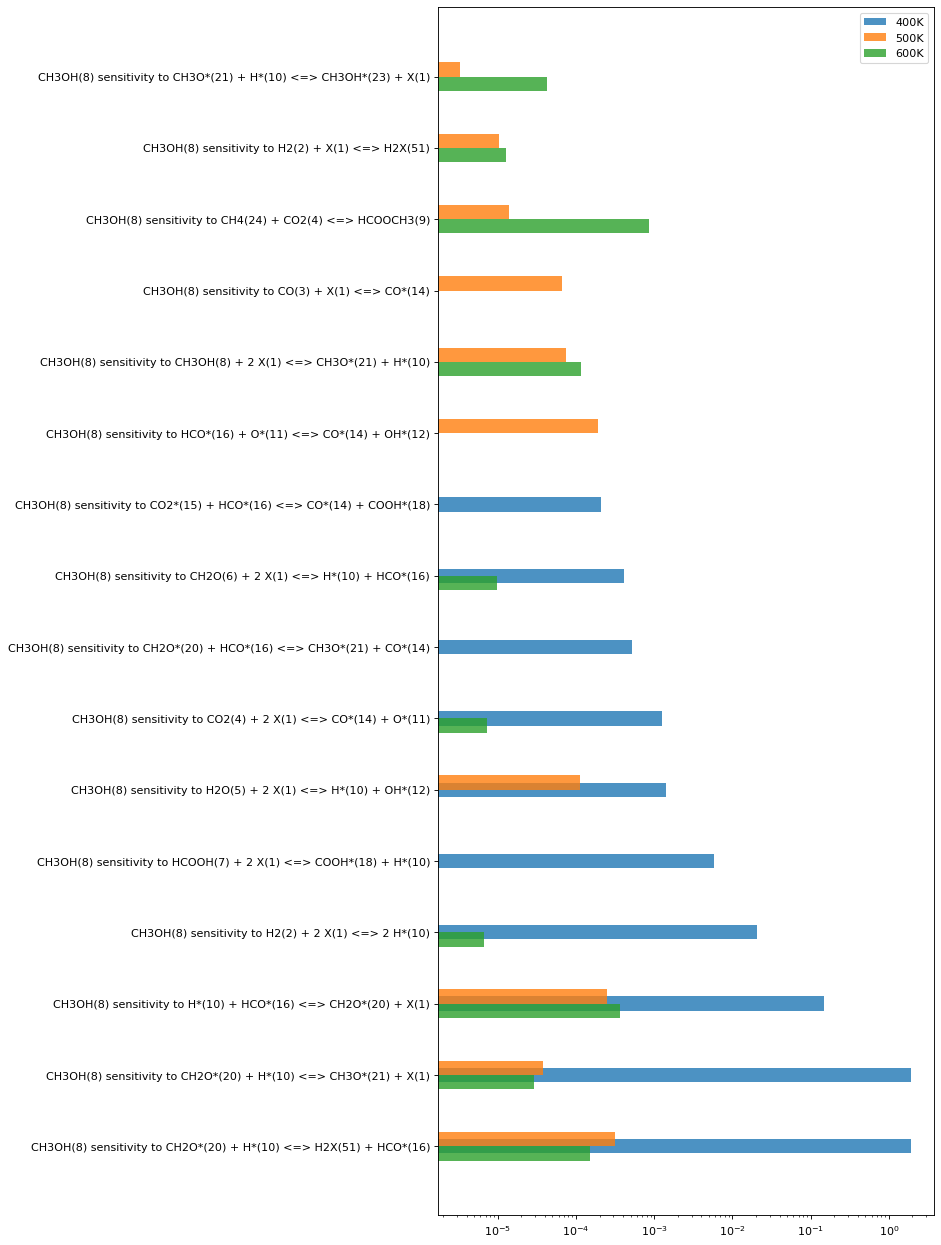

In [48]:
from matplotlib.pyplot import figure

figure(figsize=(8, 20), dpi=80)

# plot the top sensitivities for a dataframe
def plot_sensitivities(df, num = 5, align="center", height=0.2, label = ""):
    
    imp_reactions_pos, imp_reactions_neg = max_sensitivities(df,num)
    imp_reactions = {**imp_reactions_pos, **imp_reactions_neg}

    plt.barh(*zip(*imp_reactions.items()),height=height, log=True, align=align,alpha=0.8, label=label)
#     plt.show()

    plt.legend(loc='best')
#     imp_reactions_df.plot(kind='barh')

columns, columns_rev = max_sensitivities(sens_data_dict[400.0, 0.5, 0.5],5)

plot_sensitivities(sens_data_dict[400.0, 0.5, 0.5],10, "center", label="400K")
plot_sensitivities(sens_data_dict[500.0, 0.5, 0.5],10, "edge",label="500K")
plot_sensitivities(sens_data_dict[600.0, 0.5, 0.5],10, "edge", height=-0.2, label="600K")

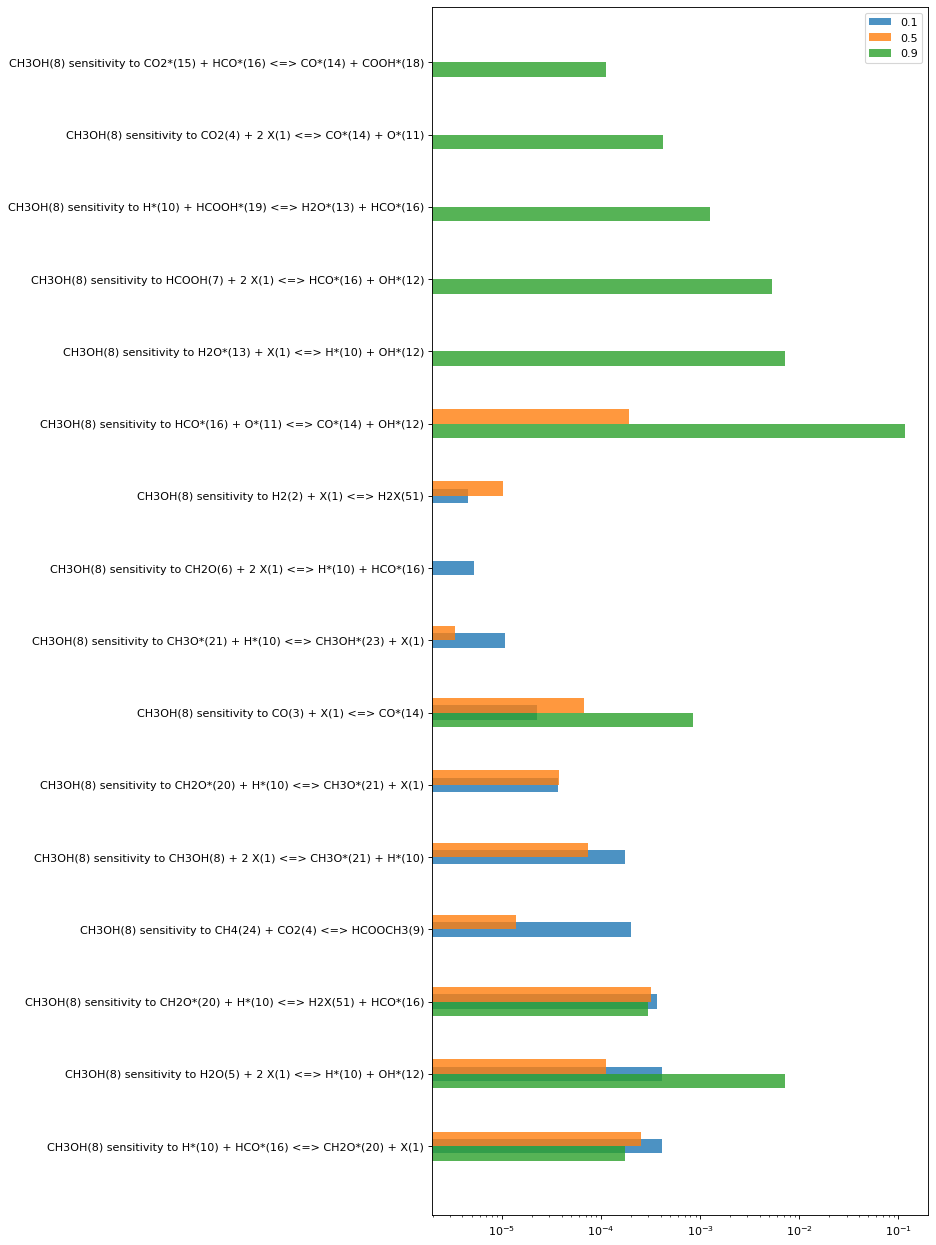

In [49]:
figure(figsize=(8, 20), dpi=80)

plot_sensitivities(sens_data_dict[500.0, 0.5, 0.1],10, "center", label="0.1")
plot_sensitivities(sens_data_dict[500.0, 0.5, 0.5],10, "edge",label="0.5")
plot_sensitivities(sens_data_dict[500.0, 0.5, 0.9],10, "edge", height=-0.2, label="0.9")

## Get common sensitivities

get common sensitive reactions (with an average sensitivity) 

In [118]:
sensitivities = {}
# i = key, j = dict
for i,j in sens_data_dict.items():
    columns, columns_rev = max_sensitivities(sens_data_dict[i],10)
    sensitivities[i] = columns


common_sensitivities = {}
# compare all of the reaction strings, and see if we have common sensitivities 
for i,j in sensitivities.items():
    for k,l in j.items():
        if k in common_sensitivities.keys():
            common_sensitivities[k] = common_sensitivities[k] + [l]
        else: 
            common_sensitivities[k] = [float(l)]
            

for i,j in common_sensitivities.items():
    common_sensitivities[i] = [sum(j) / len(j)]
    
df_sens_avg = pd.DataFrame.from_dict(common_sensitivities, orient='index', columns=["avg sensitivity"])

add reaction metadata to dataframe 

In [119]:
reactions = list(common_sensitivities.keys())
reac_species = {}
for i,j in enumerate(reactions):
    string = j[24:].replace("+"," ").replace("<=>", "").replace("2 ", "")
    string = string.split()
    
    reac_species[j] = string

In [120]:
# list of lists containing species in each reaction (makes search in cti file easier)
reac_inline = 0
comment_lines = []
reac_flag = False

with open("/work/westgroup/ChrisB/meoh-synthesis_RMG/meOH-synthesis/base/cantera/chem_annotated.cti") as f:
    for linenum,line in enumerate(f):
        if reac_flag == False:
            comment_lines = []
            # loop through dictionary n = sensitivity string and r = list of reactants
            for n,r in reac_species.items(): 
                reac_inline = 0
                if all(item in line for item in r) and not line.startswith("#"):
                    print(linenum, line)
                    reac_flag = True
                    rxn = n
                    continue
                        
                
                  
        if reac_flag == True:
            if line.startswith("#"):
                comment_lines.append(line)
            elif len(comment_lines) > 0:
                
                common_sensitivities[rxn].append(comment_lines)
                rxn = ""
                reac_flag = False

460 reaction('CO2(4) + CH4(24) <=> HCOOCH3(9)', [3.624000e+04, 2.83, 79.2],

489 surface_reaction('X(1) + X(1) + H2(2) <=> H*(10) + H*(10)', stick(3.200000e-02, 0.0, 0.0),

496 surface_reaction('X(1) + CO(3) <=> CO*(14)', stick(5.000000e-01, 0.0, 0.0),

514 surface_reaction('X(1) + H2O(5) <=> H2O*(13)', stick(1.000000e-01, 0.0, 0.0),

526 surface_reaction('X(1) + CO2(4) <=> CO2*(15)', stick(7.000000e-06, 0.0, 1.735),

537 surface_reaction('H*(10) + CO2(4) <=> HCOO*(17)', stick(1.000000e-01, 0.0, 17.462),

558 surface_reaction('H*(10) + CO2(4) <=> COOH*(18)', stick(1.000000e-01, 0.0, 17.462),

580 surface_reaction('X(1) + CH2O(6) <=> CH2O*(20)', stick(1.000000e-01, 0.0, 0.0),

632 surface_reaction('X(1) + X(1) + CO2(4) <=> O*(11) + CO*(14)', stick(2.000000e-02, 0.0, 10.0),

644 surface_reaction('X(1) + X(1) + H2O(5) <=> H*(10) + OH*(12)', stick(3.200000e-02, 0.0, 14.25),

655 surface_reaction('X(1) + X(1) + CH2O(6) <=> H*(10) + HCO*(16)', stick(3.200000e-02, 0.0, 0.0),

666 surface_reac

In [121]:
common_sensitivities

{'CH3OH(8) sensitivity to CH2O*(20) + H*(10) <=> H2X(51) + HCO*(16)': [0.1575153351367019,
  ['#  Reaction index: Chemkin #118; RMG #366\n',
   '#  Template reaction: Surface_Dual_Adsorption_vdW\n',
   '#  Estimated using template [Adsorbate1;Adsorbate2] for rate rule [O=C;H-H]\n',
   '#  Euclidian distance = 2.23606797749979\n',
   '#  Multiplied by reaction path degeneracy 2.0\n',
   '#  family: Surface_Dual_Adsorption_vdW\n']],
 'CH3OH(8) sensitivity to CH2O*(20) + H*(10) <=> CH3O*(21) + X(1)': [0.27087721444553775,
  ['#  Reaction index: Chemkin #36; RMG #127\n',
   '#  Template reaction: Surface_Addition_Single_vdW\n',
   '#  Flux pairs: CH3O2*(22), CH2O*(20); CH3O2*(22), OH*(12);\n',
   '#  Matched reaction 23 CH3O2* + X_5 <=> CH2O* + OH* in Surface_Addition_Single_vdW/training\n',
   '#  This reaction matched rate rule [O=C;HO*]\n',
   '#  family: Surface_Addition_Single_vdW\n',
   '#  metal: None\n']],
 'CH3OH(8) sensitivity to H*(10) + HCO*(16) <=> CH2O*(20) + X(1)': [0.011084

In [122]:
df_sens_avg = pd.DataFrame.from_dict(common_sensitivities, orient='index',)
df_sens_avg.to_csv("average_common_sensitivities.csv")

## get sensitive species from reactions

In [114]:
reactions = list(common_sensitivities.keys())
species = []
for i,j in enumerate(reactions):
    string = j[24:].replace("+"," ").replace("<=>", "").replace("2 ", "")
    string = string.split()
    
    for k in string:
        if k not in species:
            species.append(k)

In [115]:
len(species)

24

### get difference and see which species are less important

In [116]:
import cantera as ct
cti_file = "/work/westgroup/ChrisB/meoh-synthesis_RMG/meOH-synthesis/base/cantera/chem_annotated.cti"
gas = ct.Solution(cti_file)
surf = ct.Interface(cti_file, "surface1", [gas])

all_species = gas.species_names + surf.species_names

diff = [x for x in all_species if x not in species]
diff

['N2', 'Ne', 'CH3O2*(22)', 'COXX(63)', 'CHOX2(64)']

In [117]:
species

['CH2O*(20)',
 'H*(10)',
 'H2X(51)',
 'HCO*(16)',
 'CH3O*(21)',
 'X(1)',
 'H2(2)',
 'HCOOH(7)',
 'COOH*(18)',
 'H2O(5)',
 'OH*(12)',
 'CO2(4)',
 'CO*(14)',
 'O*(11)',
 'CH2O(6)',
 'CO2*(15)',
 'CH3OH(8)',
 'HCOOH*(19)',
 'H2O*(13)',
 'HCOO*(17)',
 'CO(3)',
 'CH3OH*(23)',
 'CH4(24)',
 'HCOOCH3(9)']

## plot a single reactor

In [33]:
commit_list

['2021_09_01_1030_08e802_ran_with_Bjarne_s_new_families,_and_grabow_rates']

In [52]:
commit_list
temp = 500 
H2_frac = "0_5"
CO_CO2 = "0_5"
element = "O"
phase = "surface1" # "surface1" "gas"
time = "end" # "end" "beginning"
csv_file= ("../RMG_model_analysis/2021_09_01_0908_7a10e2_ran_with_Bjarne_s_new_families,_and_grabow_rates/transient/IdealGasReactor/energy_off/sensitivity_off/528/results/"
            + "Spinning_basket_area_0.0231_energy_off_temp_528_h2_0_5_COCO2_0_5.csv")
# ran_with_Bjarne_s_new_families%2C_and_grabow_rates

df = pd.read_csv(csv_file)

In [53]:
df.columns

Index(['time (s)', 'T (K)', 'P (Pa)', 'V (M^3/s)', 'X_co initial',
       'X_co2initial', 'X_h2 initial', 'X_h2o initial', 'CO2/(CO2+CO)',
       '(CO+CO2/H2)',
       ...
       'H2X(53) + OH*(12) <=> H*(10) + H2O*(13) ROP [kmol/m^2 s]',
       'CO*(14) + H2X(53) <=> H*(10) + HCO*(16) ROP [kmol/m^2 s]',
       'CO2*(15) + H2X(53) <=> H*(10) + HCOO*(17) ROP [kmol/m^2 s]',
       'CO2*(15) + H2X(53) <=> COOH*(18) + H*(10) ROP [kmol/m^2 s]',
       'H2X(53) + HCOO*(17) <=> H*(10) + HCOOH*(19) ROP [kmol/m^2 s]',
       'COOH*(18) + H2X(53) <=> H*(10) + HCOOH*(19) ROP [kmol/m^2 s]',
       'CH2O*(20) + H*(10) <=> H2X(53) + HCO*(16) ROP [kmol/m^2 s]',
       'CH2O*(20) + H2X(53) <=> CH3O*(21) + H*(10) ROP [kmol/m^2 s]',
       'H2X(53) + HCOOH*(19) <=> CH3O2*(22) + H*(10) ROP [kmol/m^2 s]',
       'CH3O*(21) + H2X(53) <=> CH3OH*(23) + H*(10) ROP [kmol/m^2 s]'],
      dtype='object', length=208)

/home/blais.ch/.conda/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


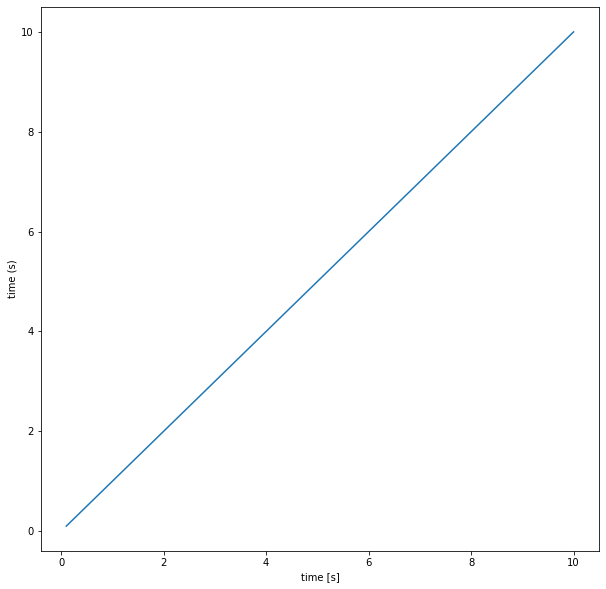

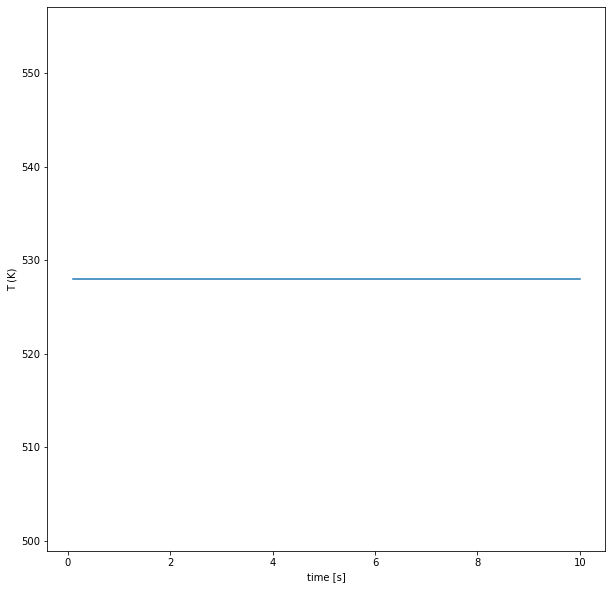

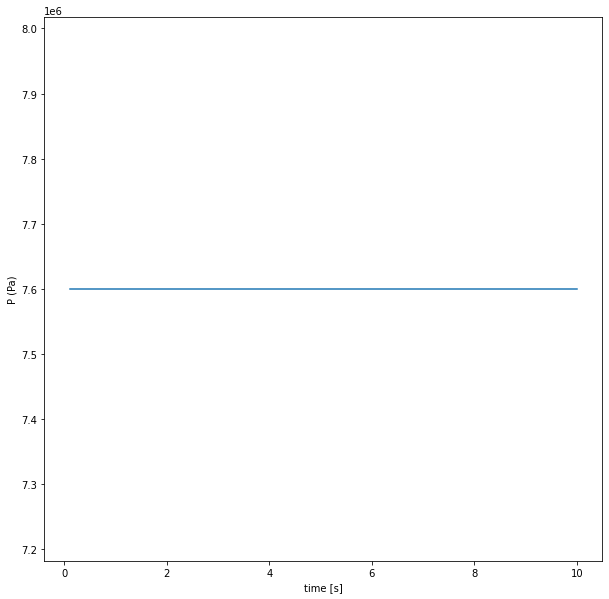

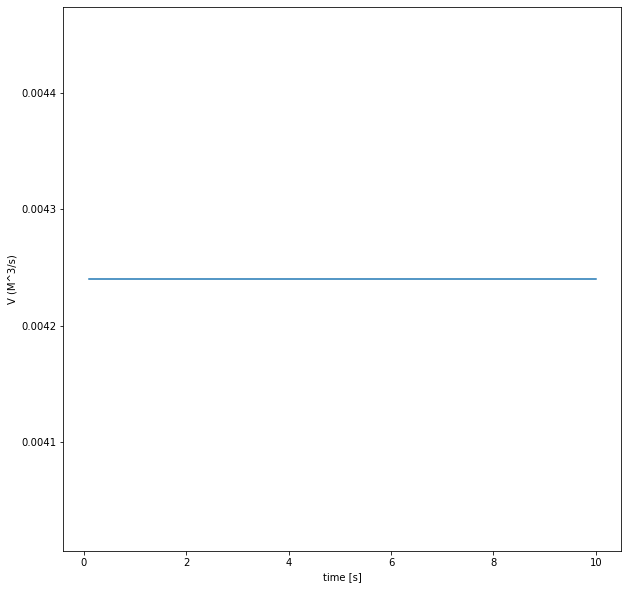

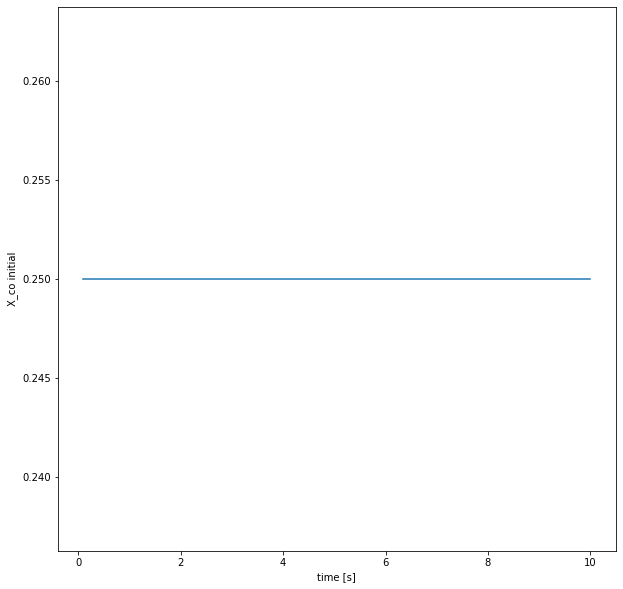

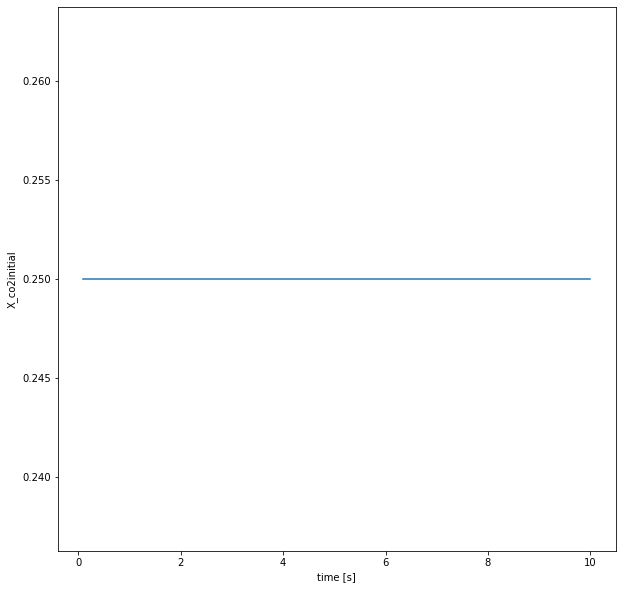

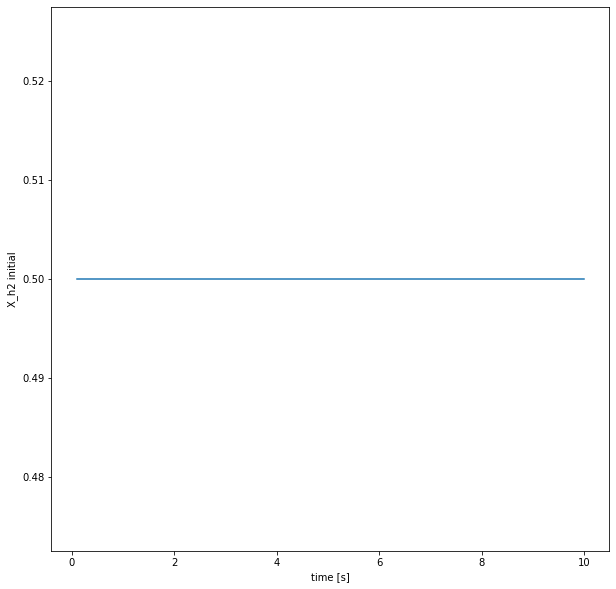

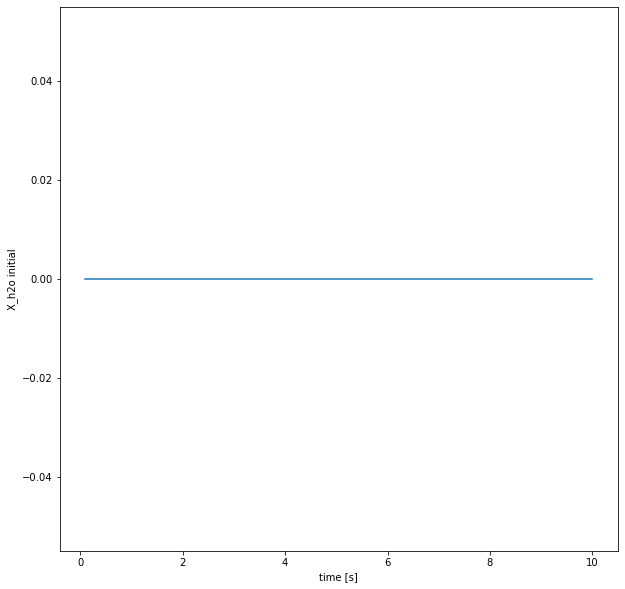

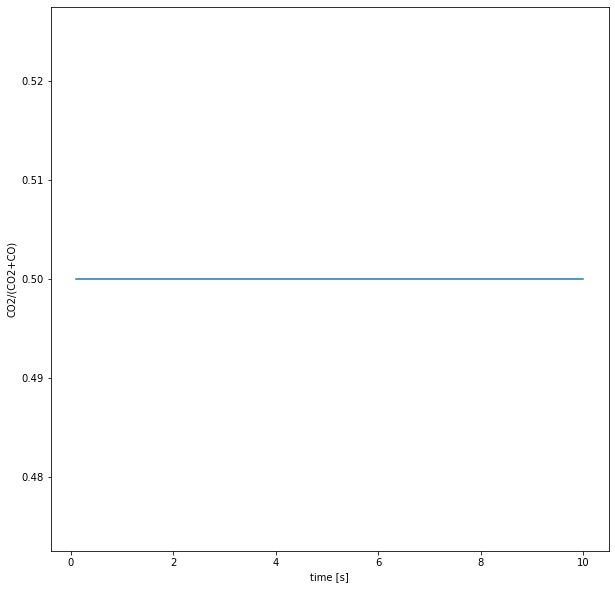

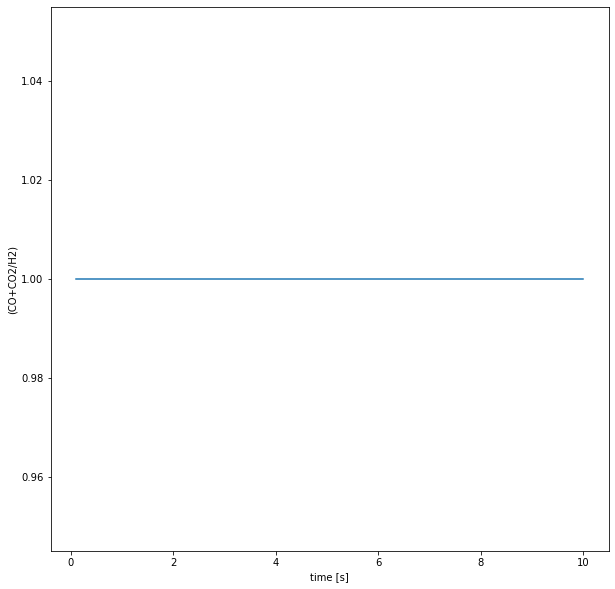

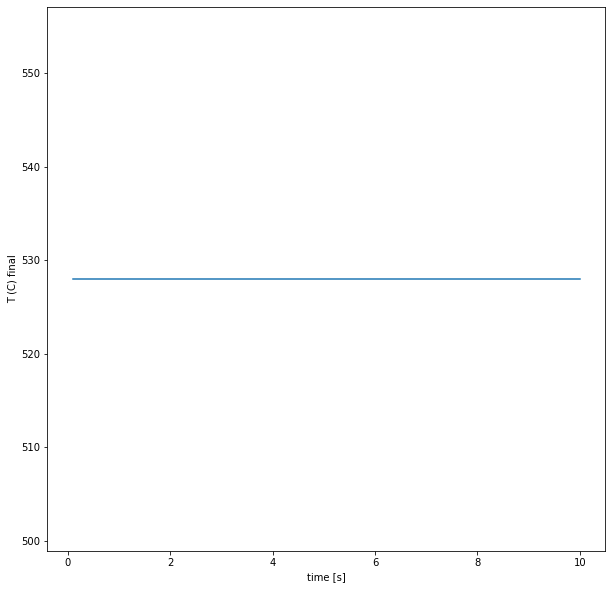

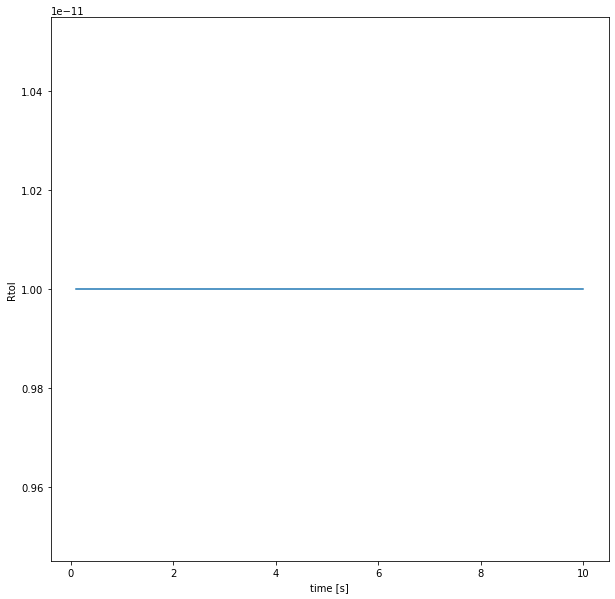

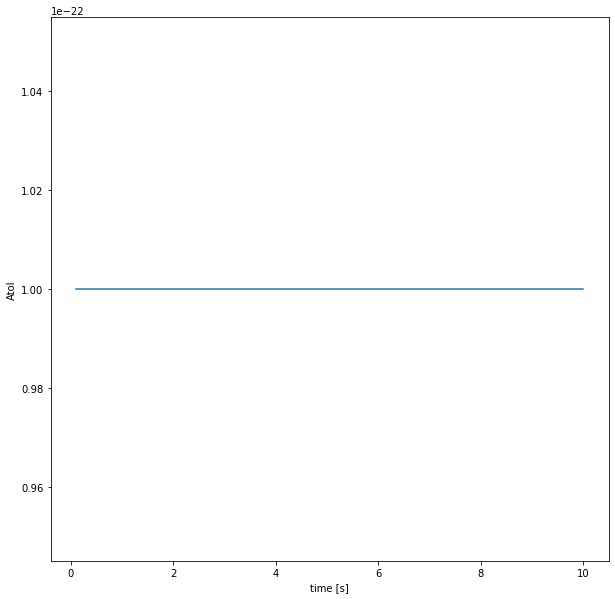

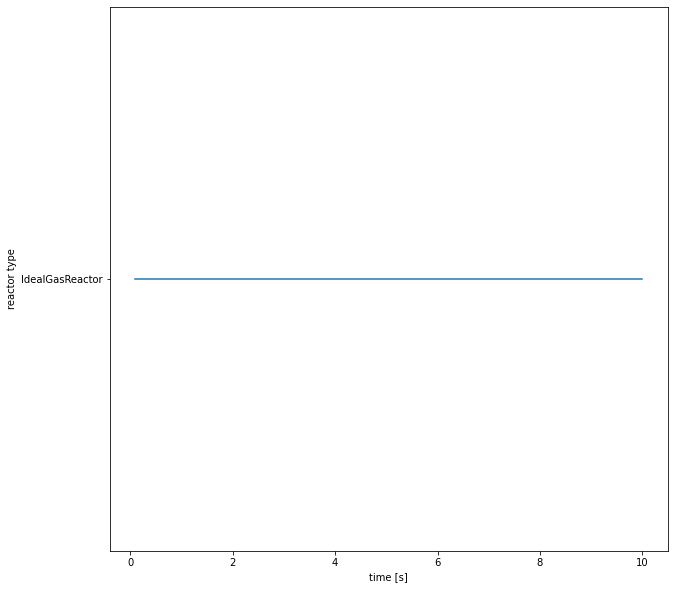

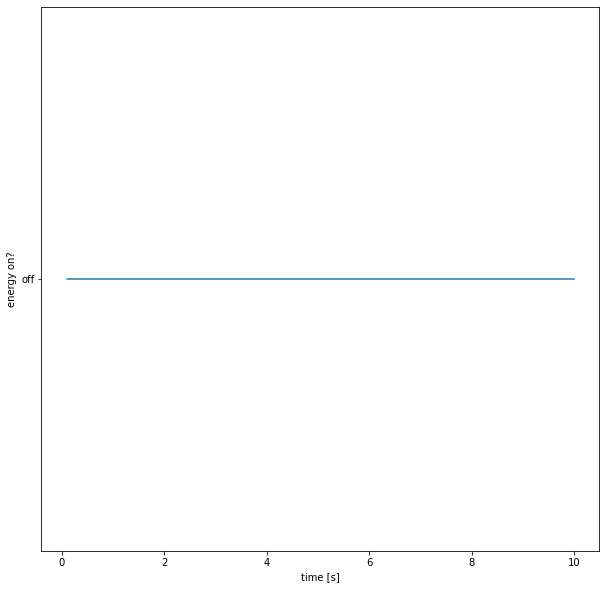

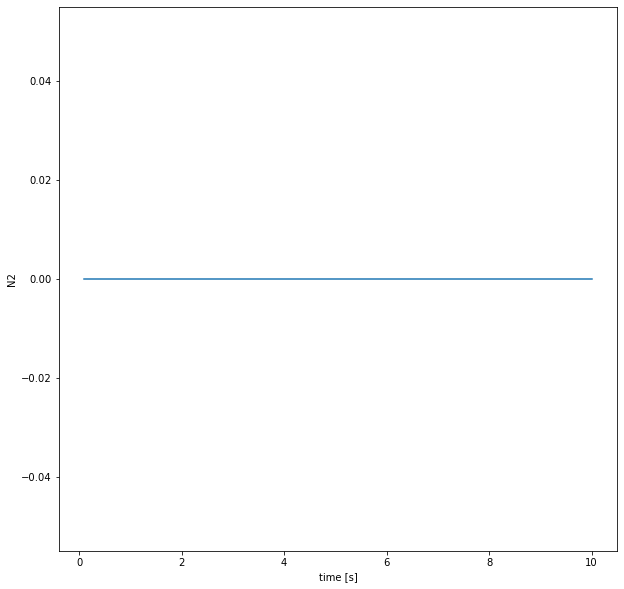

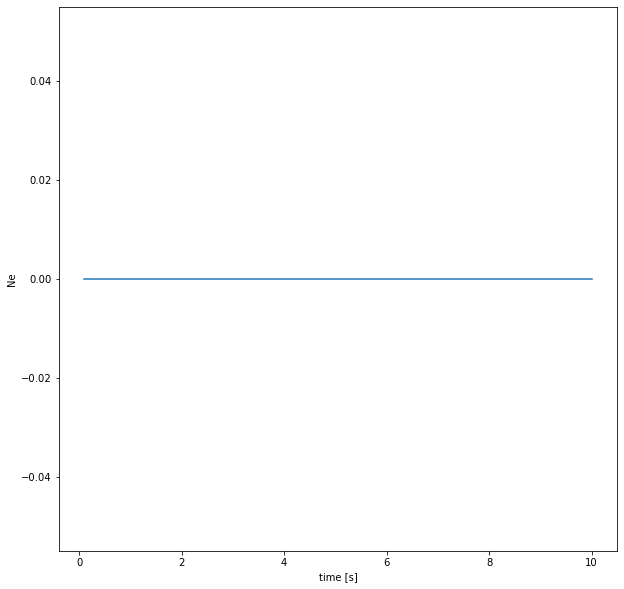

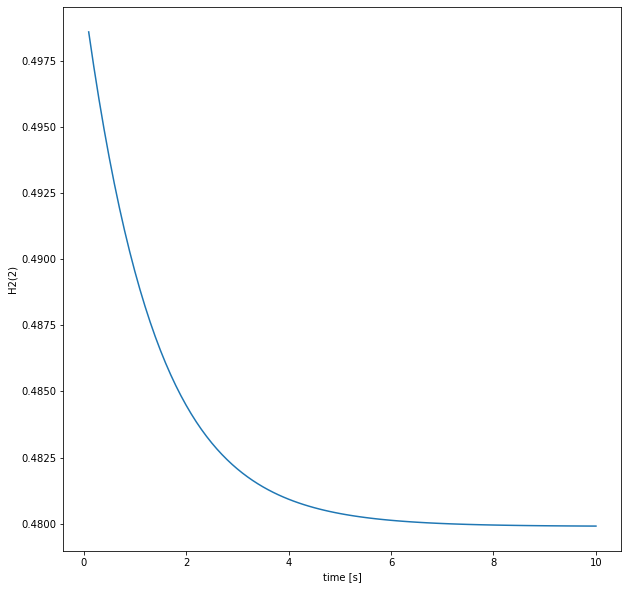

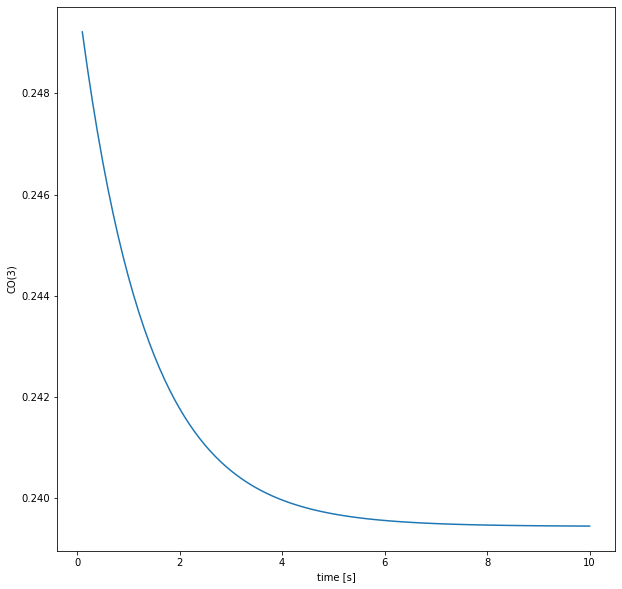

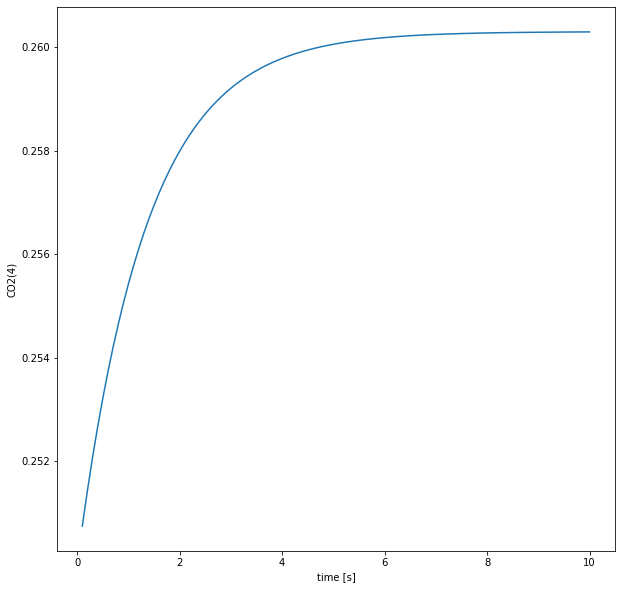

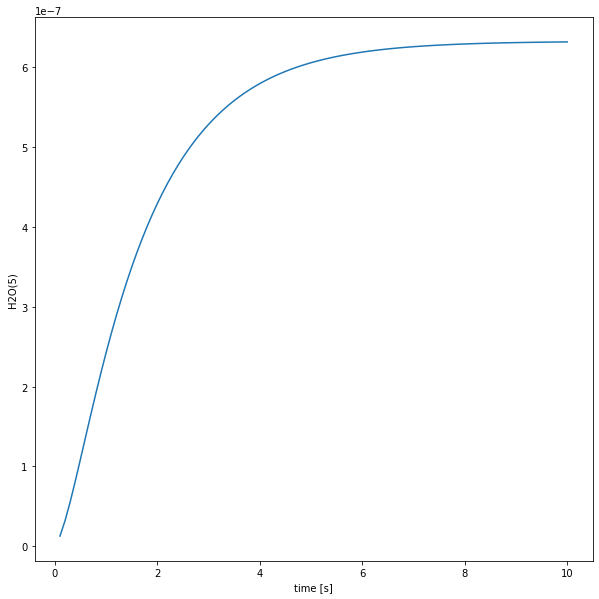

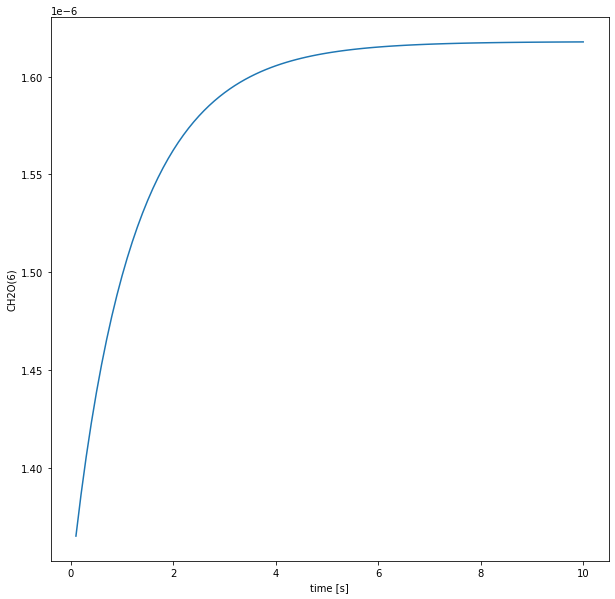

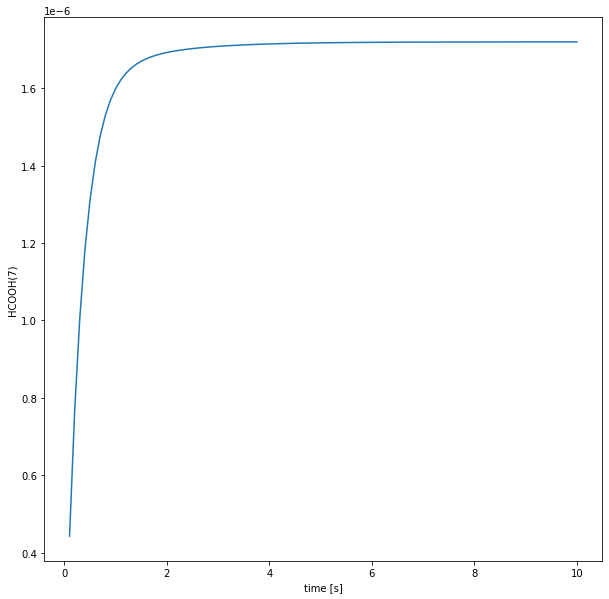

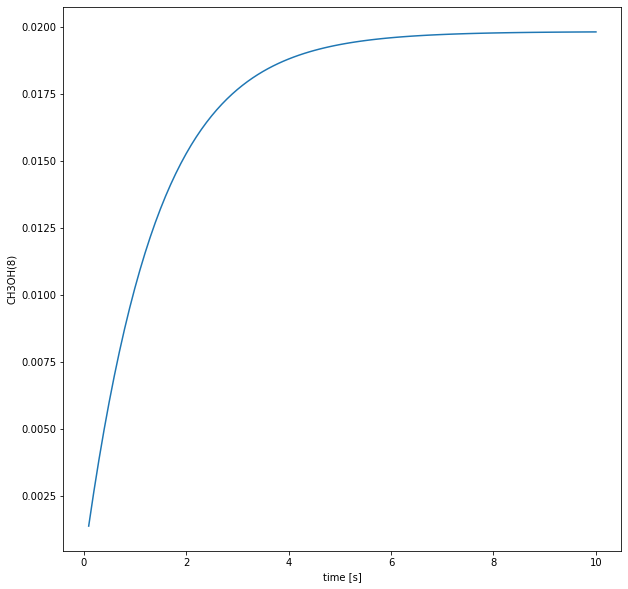

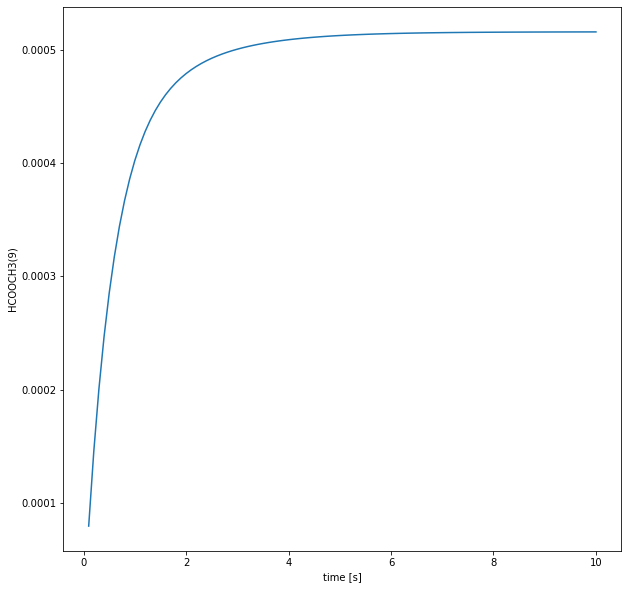

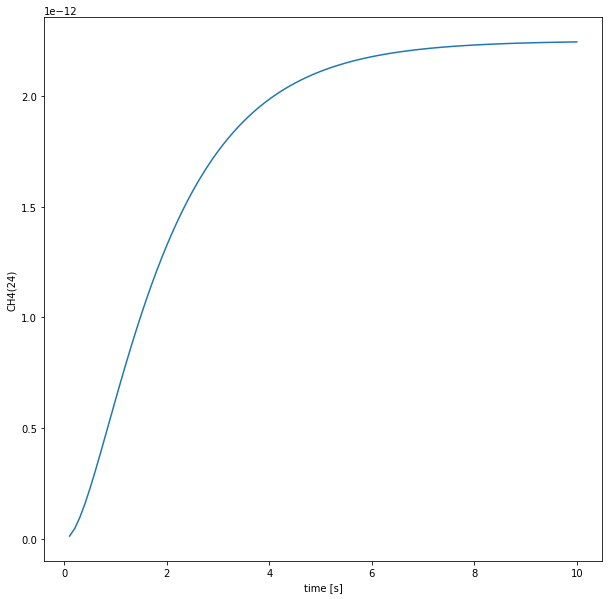

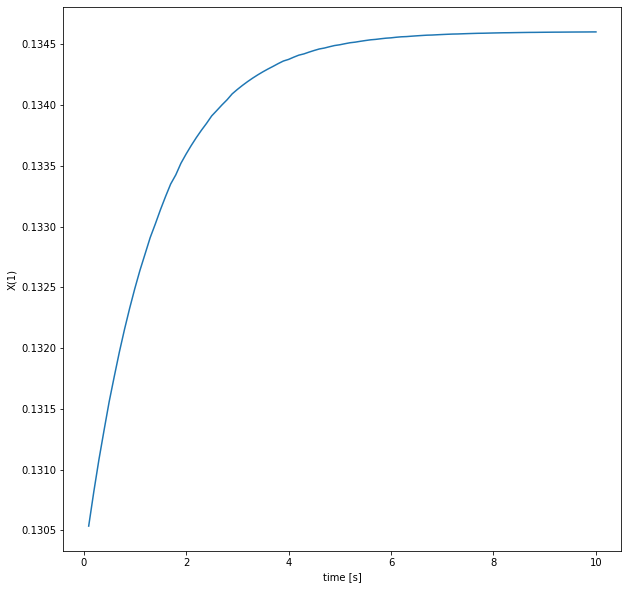

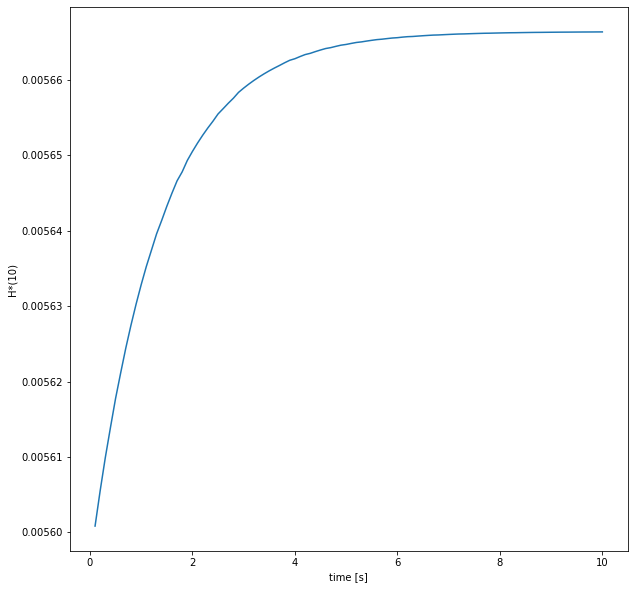

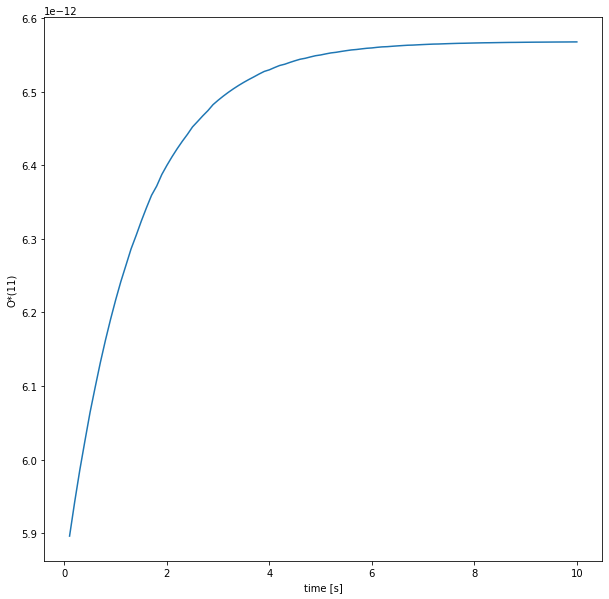

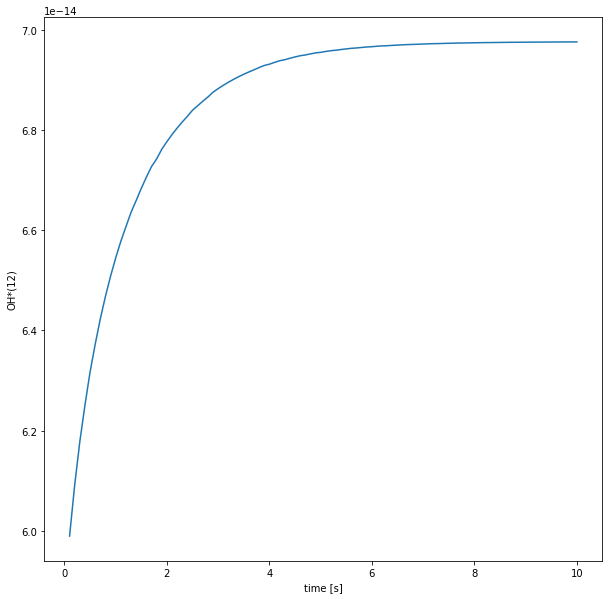

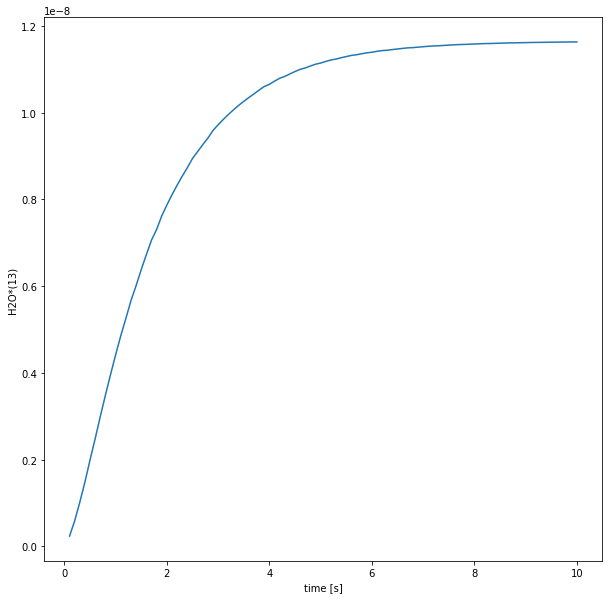

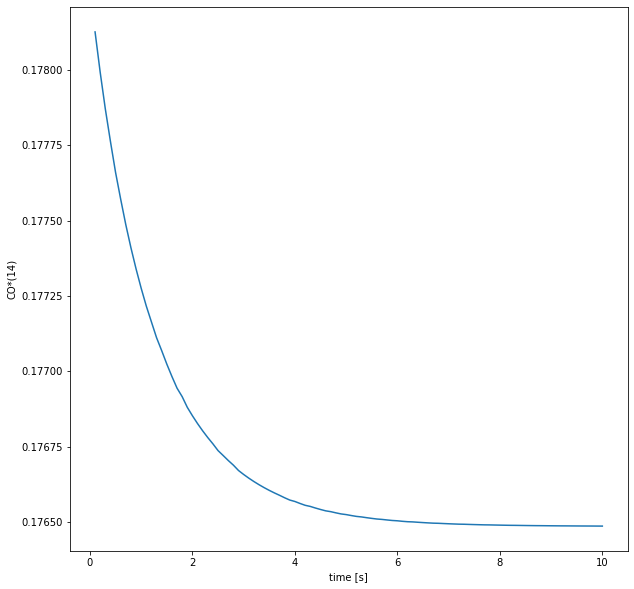

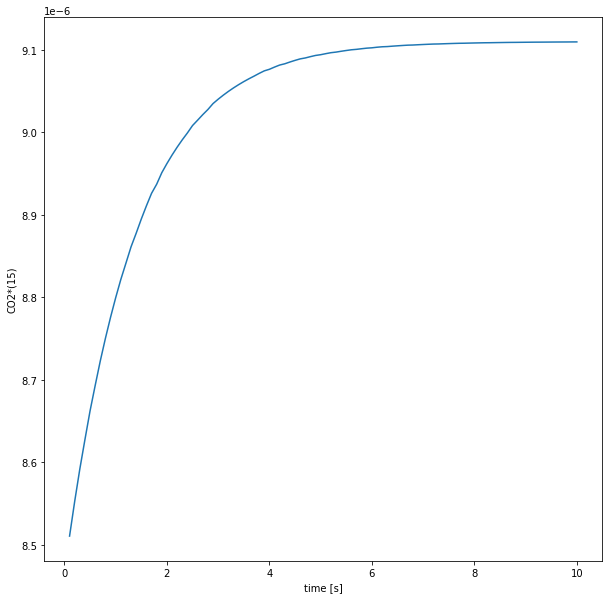

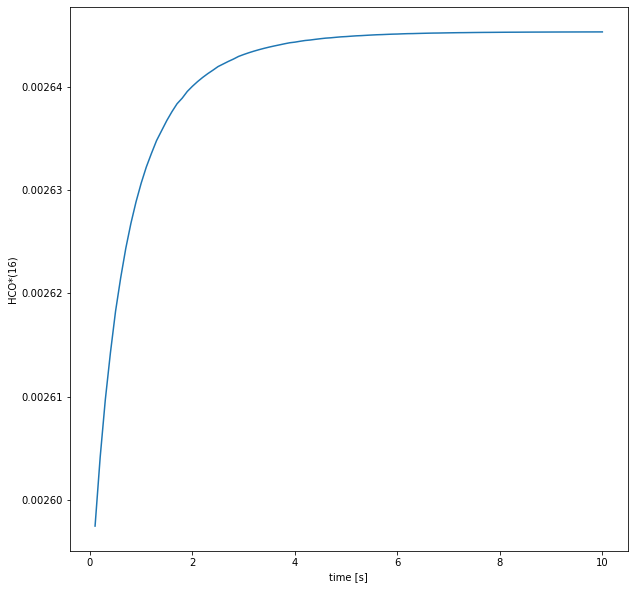

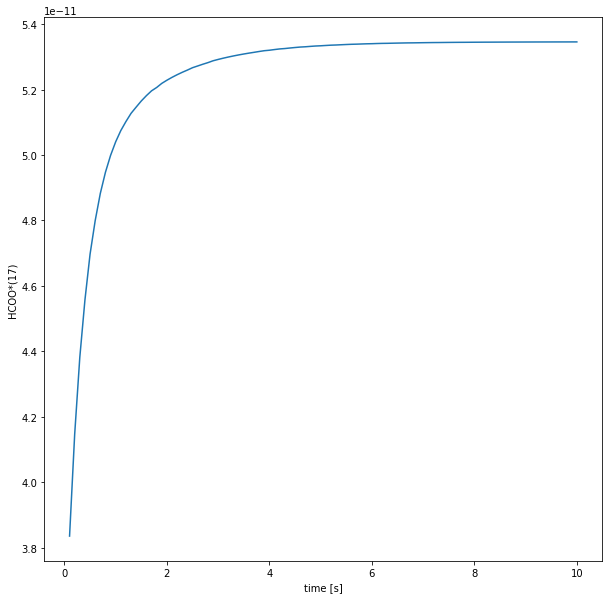

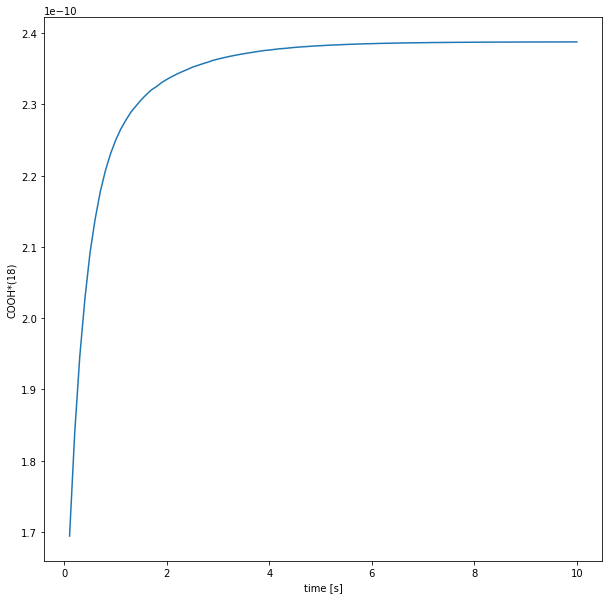

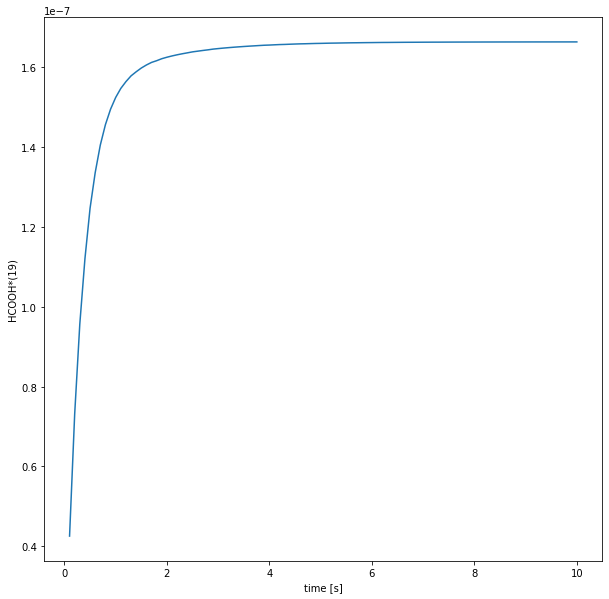

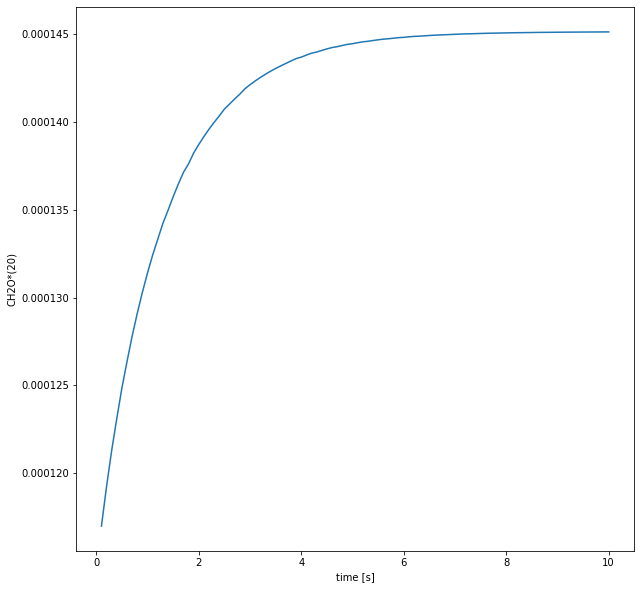

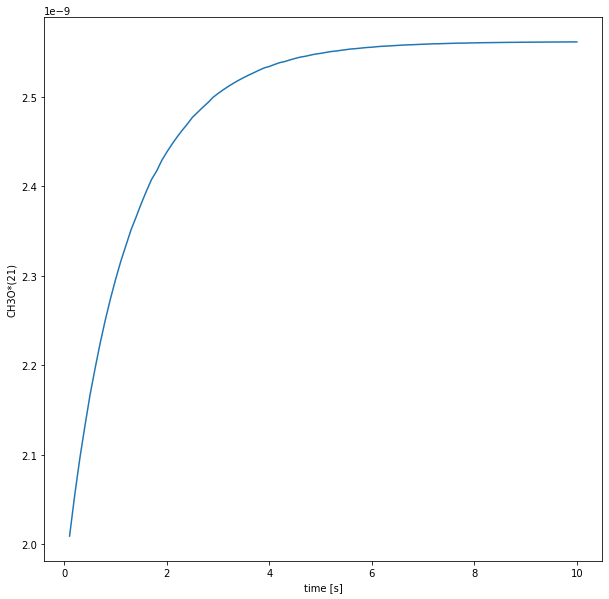

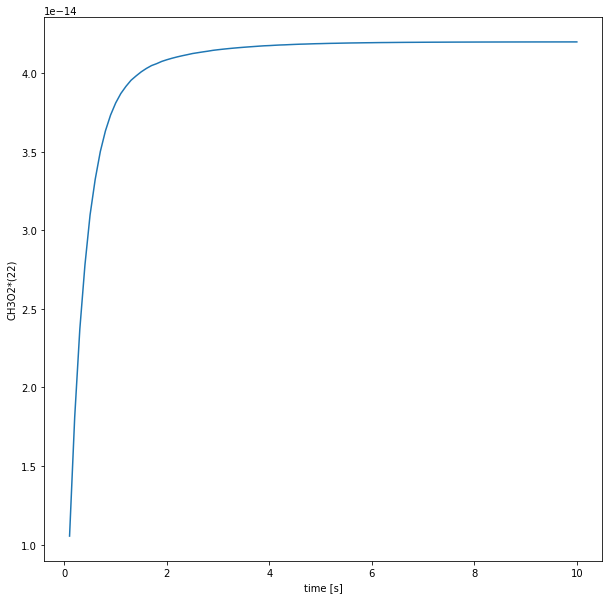

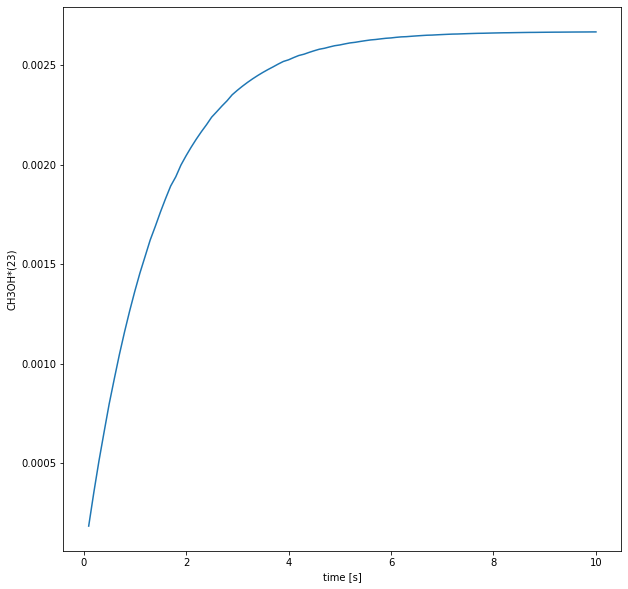

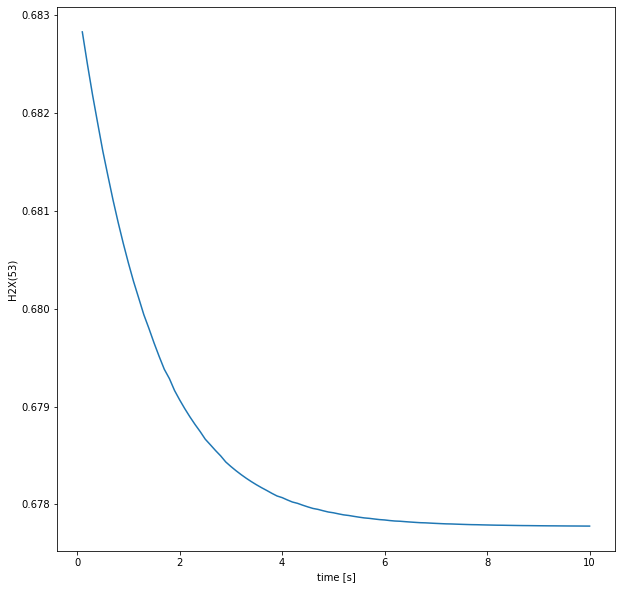

In [55]:
for col in df.columns:
    if "sensitivity" not in col and "ROP" not in col:
        plt.figure()
        plt.plot(df['time (s)'][:100], df[col][:100])
        plt.xlabel('time [s]')
        plt.ylabel(col)
    